In [1]:
# !pip install requests pandas
# !pip install pandas_ta
# Upgrade SciPy and XGBoost to versions compatible with NumPy 2.0
# !pip install "scipy>=1.13.0" xgboost --upgrade

In [2]:
import requests
import pandas as pd
import time
import os
from datetime import datetime, timedelta

def fetch_binance_history(symbol, interval='1h', years=5):
    """
    Fetches historical klines from Binance API with pagination.
    If API fails (e.g. 451 error), attempts to load from local CSV.
    """
    # 1. Calculate Start and End Times
    end_time = datetime.now()
    start_time = end_time - timedelta(days=365 * years)
    
    # Convert to int (milliseconds)
    start_ts = int(start_time.timestamp() * 1000)
    end_ts = int(end_time.timestamp() * 1000)
    
    base_url = "https://api.binance.com/api/v3/klines"
    limit = 1000 
    all_data = []
    
    print(f"🔄 Fetching {years} years of {interval} data for {symbol}...")
    
    # 2. Pagination Loop
    while True:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_ts,
            'endTime': end_ts, 
            'limit': limit
        }
        
        try:
            response = requests.get(base_url, params=params)
            
            # --- MODIFIED SECTION START ---
            if response.status_code != 200:
                print(f"⚠️ API Error: {response.status_code} (Likely Geo-blocked or Rate Limit)")
                
                # Construct filename based on user format
                filename = f"/kaggle/input/crypto/{symbol}_{interval}_5yr.csv"
                
                if os.path.exists(filename):
                    print(f"📂 Fallback: Loading local file '{filename}'...")
                    
                    # Load CSV
                    # We assume the CSV has a 'Date' column and OHLCV columns
                    df_local = pd.read_csv(filename)
                    
                    # Convert Date column to datetime objects
                    if 'Date' in df_local.columns:
                        df_local['Date'] = pd.to_datetime(df_local['Date'])
                        df_local.set_index('Date', inplace=True)
                    else:
                        # If Date is already the index in the CSV (common in pandas saves)
                        df_local.index = pd.to_datetime(df_local.index)
                        df_local.index.name = 'Date'

                    # Ensure we only select the relevant numeric columns
                    cols_needed = ['Open', 'High', 'Low', 'Close', 'Volume']
                    
                    # Basic validation to ensure columns exist
                    if all(col in df_local.columns for col in cols_needed):
                        print(f"✅ Success! Loaded {len(df_local)} rows from local file.")
                        return df_local[cols_needed]
                    else:
                        print("❌ Error: Local file missing required OHLCV columns.")
                        return pd.DataFrame() # Return empty on failure
                else:
                    print(f"❌ Error: Local file '{filename}' not found. Cannot fallback.")
                    return pd.DataFrame()
            # --- MODIFIED SECTION END ---
                
            data = response.json()
            
            # Stop if no data returned
            if not isinstance(data, list) or len(data) == 0:
                break
            
            # Append data to master list
            all_data.extend(data)
            
            # 3. Update Start Time for the next batch
            last_close_time = data[-1][6]
            start_ts = last_close_time + 1
            
            # Progress update
            if len(all_data) % 10000 == 0:
                current_date = datetime.fromtimestamp(data[-1][0]/1000)
                print(f"   ...Downloaded {len(all_data)} rows. Currently at: {current_date.strftime('%Y-%m-%d')}")
            
            # Break if we have reached the current time
            if start_ts > end_ts:
                break
            
            # 4. Rate Limit Pause
            time.sleep(0.1) 
            
        except Exception as e:
            print(f"Connection Error: {e}")
            break
            
    # 5. Convert to DataFrame (Only runs if API was successful)
    cols = ['OpenTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime', 
            'QuoteAssetVol', 'NumTrades', 'TakerBuyBase', 'TakerBuyQuote', 'Ignore']
    
    df = pd.DataFrame(all_data, columns=cols)
    
    if not df.empty:
        # Post-Processing
        df['Date'] = pd.to_datetime(df['OpenTime'], unit='ms')
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, axis=1)
        df.set_index('Date', inplace=True)
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
        print(f"✅ Success! Fetched {len(df)} rows for {symbol} from API.")
        return df
    
    return pd.DataFrame()

In [3]:
import os  # Import os to handle directory creation

# --- EXECUTION SECTION ---

# Define your symbols (Binance format: No dash, usually USDT pairs)
symbols = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT']
data_store = {}

# Define the output folder
output_folder = 'analysis_data/crypto_data'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"📁 Created directory: {output_folder}")

for sym in symbols:
    # Fetch 5 years of 1-hour data
    df = fetch_binance_history(sym, interval='1h', years=5)
    data_store[sym] = df
    
    # Save to CSV in the 'crypto_data' folder
    filename = os.path.join(output_folder, f"{sym}_1h_5yr.csv")
    df.to_csv(filename)
    print(f"   Saved to {filename}\n")

# Verify the data
print("\nSample Data (Head of BTC):")
if 'BTCUSDT' in data_store:
    print(data_store['BTCUSDT'].head())

🔄 Fetching 5 years of 1h data for BTCUSDT...
⚠️ API Error: 451 (Likely Geo-blocked or Rate Limit)
📂 Fallback: Loading local file '/kaggle/input/crypto/BTCUSDT_1h_5yr.csv'...
✅ Success! Loaded 43781 rows from local file.
   Saved to analysis_data/crypto_data/BTCUSDT_1h_5yr.csv

🔄 Fetching 5 years of 1h data for ETHUSDT...
⚠️ API Error: 451 (Likely Geo-blocked or Rate Limit)
📂 Fallback: Loading local file '/kaggle/input/crypto/ETHUSDT_1h_5yr.csv'...
✅ Success! Loaded 43781 rows from local file.
   Saved to analysis_data/crypto_data/ETHUSDT_1h_5yr.csv

🔄 Fetching 5 years of 1h data for LTCUSDT...
⚠️ API Error: 451 (Likely Geo-blocked or Rate Limit)
📂 Fallback: Loading local file '/kaggle/input/crypto/LTCUSDT_1h_5yr.csv'...
✅ Success! Loaded 43781 rows from local file.
   Saved to analysis_data/crypto_data/LTCUSDT_1h_5yr.csv


Sample Data (Head of BTC):
                         Open      High       Low     Close       Volume
Date                                                             

In [4]:
data_store['BTCUSDT'].shape

(43781, 5)

In [5]:
data_store['ETHUSDT'].shape

(43781, 5)

In [6]:
data_store['LTCUSDT'].shape

(43781, 5)

In [7]:
import pandas as pd
import os

# --- CONFIGURATION ---
# Define the mathematical logic for OHLCV aggregation
aggregation_rules = {
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}

print("Starting Resampling Process (from Memory)...\n" + "="*50)

# 1. Initialize a new dictionary to hold the nested structure
# We use a temporary variable to avoid modifying 'data_store' while iterating over it
new_data_store = {}
output_folder = 'analysis_data/crypto_data'
# Iterate directly over the existing dictionary (assuming it currently holds 1H DataFrames)
for symbol, df_1h in data_store.items():
    print(f"📉 Processing {symbol}...")
    
    # Safety Check: Ensure the index is Datetime and sorted
    if not isinstance(df_1h.index, pd.DatetimeIndex):
        df_1h.index = pd.to_datetime(df_1h.index)
    df_1h = df_1h.sort_index()

    # Initialize the inner dictionary for this symbol
    new_data_store[symbol] = {}

    # --- STORE 1-HOUR HORIZON ---
    new_data_store[symbol]['1h'] = df_1h.copy()
    # (Optional) Save 1H to CSV if you haven't already
    # df_1h.to_csv(f"{symbol}_1h_5yr.csv")

    # --- PROCESS 4-HOUR HORIZON ---
    # '4h' = 4 Hours. dropna() removes empty periods.
    df_4h = df_1h.resample('4h').agg(aggregation_rules).dropna()
    
    # Store in dictionary
    new_data_store[symbol]['4h'] = df_4h
    
    # Save to CSV
    filename_4h = os.path.join(output_folder,f"{symbol}_4h_5yr.csv")
    df_4h.to_csv(filename_4h)
    print(f"   ✅ Created 4H data: {filename_4h} ({len(df_4h)} rows)")

    # --- PROCESS 24-HOUR HORIZON ---
    # '1D' = 1 Day.
    df_24h = df_1h.resample('1D').agg(aggregation_rules).dropna()
    
    # Store in dictionary
    new_data_store[symbol]['24h'] = df_24h
        
    # Save to CSV
    filename_24h = os.path.join(output_folder,f"{symbol}_24h_5yr.csv")
    df_24h.to_csv(filename_24h)
    print(f"   ✅ Created 24H data: {filename_24h} ({len(df_24h)} rows)")
        
    print("-" * 40)

# 2. Update the main variable to the new structure
data_store = new_data_store

print("\n🎉 Resampling Complete!")
print("Access data using: data_store['SYMBOL']['HORIZON']")
print("Example: data_store['BTCUSDT']['4h'].head()")

Starting Resampling Process (from Memory)...
📉 Processing BTCUSDT...
   ✅ Created 4H data: analysis_data/crypto_data/BTCUSDT_4h_5yr.csv (10951 rows)
   ✅ Created 24H data: analysis_data/crypto_data/BTCUSDT_24h_5yr.csv (1826 rows)
----------------------------------------
📉 Processing ETHUSDT...
   ✅ Created 4H data: analysis_data/crypto_data/ETHUSDT_4h_5yr.csv (10951 rows)
   ✅ Created 24H data: analysis_data/crypto_data/ETHUSDT_24h_5yr.csv (1826 rows)
----------------------------------------
📉 Processing LTCUSDT...
   ✅ Created 4H data: analysis_data/crypto_data/LTCUSDT_4h_5yr.csv (10951 rows)
   ✅ Created 24H data: analysis_data/crypto_data/LTCUSDT_24h_5yr.csv (1826 rows)
----------------------------------------

🎉 Resampling Complete!
Access data using: data_store['SYMBOL']['HORIZON']
Example: data_store['BTCUSDT']['4h'].head()


In [8]:
import pandas as pd
import pandas_ta as ta
import numpy as np

# --- CONFIGURATION ---
# Define Feature Engineering Logic
def engineer_features(df):
    """
    Applies technical analysis and feature engineering to a single DataFrame.
    Returns the modified DataFrame with new columns.
    """
    # Avoid SettingWithCopyWarning
    df = df.copy()
    
    # 1. Targets: Log Returns
    # Formula: ln(Price_t / Price_t-1)
    # We use 'Close' price for the return calculation
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # 2. Time: Cyclical Encodings
    # We use the index (which is Datetime) to extract Hour and Day of Week
    # Hour: 0-23, Day: 0-6 (Monday=0, Sunday=6)
    
    # Sine/Cosine for Hour (Period = 24)
    df['Hour_Sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['Hour_Cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    
    # Sine/Cosine for Day of Week (Period = 7)
    df['Day_Sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['Day_Cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    
    # 3. Indicators: RSI, MACD, ATR, Volume Delta
    # Using pandas_ta for efficiency
    
    # RSI (Relative Strength Index, default window=14)
    df['RSI'] = df.ta.rsi(length=14)
    
    # MACD (Moving Average Convergence Divergence)
    # Returns a DataFrame with columns like MACD_12_26_9, MACDh_12_26_9 (Histogram), MACDs_12_26_9 (Signal)
    macd = df.ta.macd(fast=12, slow=26, signal=9)
    df = pd.concat([df, macd], axis=1) # Append all MACD columns to main DF
    
    # ATR (Average True Range, volatility measure, default window=14)
    df['ATR'] = df.ta.atr(length=14)
    
    # Volume Delta
    # Simple difference: Current Volume - Previous Volume
    df['Volume_Delta'] = df['Volume'].diff()
    
    # 4. Clean Up
    # Drop rows with NaN values created by lag features (e.g., first 26 rows for MACD)
    df.dropna(inplace=True)
    
    return df


In [9]:
# --- EXECUTION ---
print("Starting Feature Engineering...\n" + "="*50)

# We will update the existing data_store in place
# Structure: data_store[symbol][horizon] -> DataFrame

for symbol in data_store.keys():
    print(f"🛠  Processing {symbol}...")
    
    for horizon in data_store[symbol].keys():
        # Get the raw DataFrame
        raw_df = data_store[symbol][horizon]
        
        # Apply Feature Engineering
        processed_df = engineer_features(raw_df)
        
        # Update the dictionary with the new DataFrame
        data_store[symbol][horizon] = processed_df
        
        # Optional: Print shape to verify data loss from dropna()
        print(f"   -> {horizon}: Features added. New shape: {processed_df.shape}")
        
    print("-" * 30)

print("\n✅ Feature Engineering Complete.")
print("New columns available: Log_Returns, Hour_Sin, Hour_Cos, Day_Sin, Day_Cos, RSI, ATR, MACD...")

Starting Feature Engineering...
🛠  Processing BTCUSDT...
   -> 1h: Features added. New shape: (43748, 16)
   -> 4h: Features added. New shape: (10918, 16)
   -> 24h: Features added. New shape: (1793, 16)
------------------------------
🛠  Processing ETHUSDT...
   -> 1h: Features added. New shape: (43748, 16)
   -> 4h: Features added. New shape: (10918, 16)
   -> 24h: Features added. New shape: (1793, 16)
------------------------------
🛠  Processing LTCUSDT...
   -> 1h: Features added. New shape: (43748, 16)
   -> 4h: Features added. New shape: (10918, 16)
   -> 24h: Features added. New shape: (1793, 16)
------------------------------

✅ Feature Engineering Complete.
New columns available: Log_Returns, Hour_Sin, Hour_Cos, Day_Sin, Day_Cos, RSI, ATR, MACD...


In [10]:
data_store['BTCUSDT']['1h'].tail()

,Open,High,Low,Close,Volume,Log_Returns,Hour_Sin,Hour_Cos,Day_Sin,Day_Cos,RSI,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ATR,Volume_Delta
Date,,,,,,,,,,,,,,,,
2025-12-17 16:00:00,87233.44,87769.23,86166.66,86986.51,2213.28706,-0.002835,-0.866025,-5.000000e-01,0.974928,-0.222521,48.037516,84.835041,69.662713,15.172329,964.842744,-1887.32197
2025-12-17 17:00:00,86986.50,87103.44,86265.15,86427.12,812.72770,-0.006452,-0.965926,-2.588190e-01,0.974928,-0.222521,44.439208,5.553101,-7.695382,13.248483,955.803262,-1400.55936
2025-12-17 18:00:00,86427.12,86850.64,85662.46,85829.22,910.41728,-0.006942,-1.000000,-1.836970e-16,0.974928,-0.222521,40.911732,-104.321388,-94.055897,-10.265491,972.401600,97.68958
2025-12-17 19:00:00,85829.25,86195.38,85314.00,86018.53,1109.18442,0.002203,-0.965926,2.588190e-01,0.974928,-0.222521,42.468881,-174.114890,-131.079519,-43.035371,965.900058,198.76714
2025-12-17 20:00:00,86018.53,86252.16,85644.09,85983.56,521.04809,-0.000407,-0.866025,5.000000e-01,0.974928,-0.222521,42.247401,-229.601823,-149.253162,-80.348661,940.340768,-588.13633


In [11]:
import numpy as np
import pandas as pd

# --- CONFIGURATION ---
# Window size: How many past steps the model sees to predict the next step
# 1h: 60 hours lookback
# 4h: 30 steps (120 hours) lookback
# 24h: 30 steps (30 days) lookback
WINDOW_SIZES = {
    '1h': 60,
    '4h': 30,
    '24h': 30
}

# Features to use for ML/DL (Stationary inputs only)
# We exclude raw 'Open', 'High', 'Low', 'Close' to prevent non-stationarity issues
FEATURE_COLS = [
    'Log_Returns', 
    'Volume_Delta', 
    'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos',
    'RSI', 'ATR', 
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9'
]

def create_sliding_window(data, window_size):
    """
    Efficiently creates sliding window view using numpy strides.
    Returns X (Samples, Window, Features) and y (Samples,)
    """
    # Convert dataframe to numpy array
    X_data = data[FEATURE_COLS].values
    y_data = data['Log_Returns'].values  # Target is usually the NEXT Log Return

    X, y = [], []
    
    # We iterate up to len-1 because we need the NEXT value as target
    # Range: Start from window_size, end at len(data) - 1
    # Example: If Window=60, we need indices 0-59 to predict index 60.
    
    # Efficient numpy approach
    # Shape: (Samples, Window, Features)
    num_samples = len(data) - window_size
    
    # Pre-allocate arrays for speed
    X = np.zeros((num_samples, window_size, len(FEATURE_COLS)))
    y = np.zeros((num_samples,))
    
    for i in range(num_samples):
        # Input: rows i to i+window
        X[i] = X_data[i : i+window_size]
        # Target: The return at i+window (the next step)
        y[i] = y_data[i + window_size]
        
    return X, y


In [12]:
# --- EXECUTION ---
print("Generating Data Views (Raw, Flat, Sequence)...\n" + "="*50)

# New storage structure: final_views[symbol][horizon]['raw'|'flat'|'seq']
final_views = {}

for symbol in data_store.keys():
    print(f"📦 Processing Views for {symbol}...")
    final_views[symbol] = {}
    
    for horizon in data_store[symbol].keys():
        # 1. Get processed DataFrame
        df = data_store[symbol][horizon]
        window = WINDOW_SIZES.get(horizon, 60) # Default to 60 if missing
        
        # Initialize horizon dict
        final_views[symbol][horizon] = {}
        
        # --- VIEW A: RAW (For SMA) ---
        # Keep Index and Close Price. 
        # We also keep Log_Returns for calculating the baseline's accuracy later.
        final_views[symbol][horizon]['raw'] = df[['Close', 'Log_Returns']].copy()
        
        # --- VIEW C: SEQUENCE (For LSTM/GRU) ---
        # Shape: (Samples, Window_Size, Features)
        X_seq, y_seq = create_sliding_window(df, window)
        
        final_views[symbol][horizon]['seq'] = {
            'X': X_seq,
            'y': y_seq,
            'feature_names': FEATURE_COLS
        }
        
        # --- VIEW B: FLAT (For XGBoost) ---
        # Shape: (Samples, Window_Size * Features)
        # We can just reshape the Sequence view!
        # (N, W, F) -> (N, W*F)
        samples, win, feats = X_seq.shape
        X_flat = X_seq.reshape(samples, win * feats)
        
        final_views[symbol][horizon]['flat'] = {
            'X': X_flat,
            'y': y_seq, # Target is same as sequence view
            'feature_names': [f"{col}_lag{i}" for i in range(win) for col in FEATURE_COLS]
        }
        
        print(f"   -> {horizon} Views Created:")
        print(f"      Raw: {final_views[symbol][horizon]['raw'].shape}")
        print(f"      Seq: {X_seq.shape} (LSTM input)")
        print(f"      Flat: {X_flat.shape} (XGB input)")

print("-" * 30)
print("\n✅ All Views Generated.")
print("Access example: final_views['BTCUSDT']['1h']['seq']['X']")

Generating Data Views (Raw, Flat, Sequence)...
📦 Processing Views for BTCUSDT...
   -> 1h Views Created:
      Raw: (43748, 2)
      Seq: (43688, 60, 11) (LSTM input)
      Flat: (43688, 660) (XGB input)
   -> 4h Views Created:
      Raw: (10918, 2)
      Seq: (10888, 30, 11) (LSTM input)
      Flat: (10888, 330) (XGB input)
   -> 24h Views Created:
      Raw: (1793, 2)
      Seq: (1763, 30, 11) (LSTM input)
      Flat: (1763, 330) (XGB input)
📦 Processing Views for ETHUSDT...
   -> 1h Views Created:
      Raw: (43748, 2)
      Seq: (43688, 60, 11) (LSTM input)
      Flat: (43688, 660) (XGB input)
   -> 4h Views Created:
      Raw: (10918, 2)
      Seq: (10888, 30, 11) (LSTM input)
      Flat: (10888, 330) (XGB input)
   -> 24h Views Created:
      Raw: (1793, 2)
      Seq: (1763, 30, 11) (LSTM input)
      Flat: (1763, 330) (XGB input)
📦 Processing Views for LTCUSDT...
   -> 1h Views Created:
      Raw: (43748, 2)
      Seq: (43688, 60, 11) (LSTM input)
      Flat: (43688, 660) (XGB i

Strategy Implementation (Golden Cross Logic)
This cell defines the function to calculate the indicators and generating the raw signals (1 = Long, 0 = Cash).

In [13]:
# --- CELL 1: DEFINE SMA STRATEGY ---
import numpy as np
import pandas as pd

def apply_sma_strategy(df, fast_window=10, slow_window=50):
    """
    Calculates SMA indicators and generates Golden Cross signals.
    """
    df = df.copy()
    
    # 1. Calculate Moving Averages
    df['SMA_Fast'] = df['Close'].rolling(window=fast_window).mean()
    df['SMA_Slow'] = df['Close'].rolling(window=slow_window).mean()
    
    # 2. Generate Signals
    # Position = 1 when Fast > Slow (Long)
    # Position = 0 when Fast < Slow (Cash/Neutral)
    df['Position'] = np.where(df['SMA_Fast'] > df['SMA_Slow'], 1, 0)
    
    return df.dropna()

print("✅ Strategy Function 'apply_sma_strategy' defined.")

✅ Strategy Function 'apply_sma_strategy' defined.


Simulation (Run on Test Period)
This cell selects the Test Period (the most recent 20% of data) and calculates the raw strategy returns before fees.

In [14]:
# --- CELL 2: RUN SIMULATION (BACKTEST) ---

# Configuration: Split parameters
TEST_SIZE_PCT = 0.2  # Use last 20% of data for testing

sma_results = {}

print(f"Running SMA Simulation on Test Data (Last {TEST_SIZE_PCT*100}%)...\n" + "="*50)

for symbol in final_views.keys():
    sma_results[symbol] = {}
    
    for horizon in final_views[symbol].keys():
        # 1. Get Raw Data
        df_raw = final_views[symbol][horizon]['raw'].copy()
        
        # 2. Split Train/Test (Time-based)
        split_idx = int(len(df_raw) * (1 - TEST_SIZE_PCT))
        df_test = df_raw.iloc[split_idx:].copy()
        
        # 3. Apply Strategy
        df_test = apply_sma_strategy(df_test, fast_window=10, slow_window=50)
        
        # 4. Calculate Raw Strategy Returns
        # We shift Position by 1 because a signal at hour T acts on returns at T+1
        df_test['Strategy_Return'] = df_test['Position'].shift(1) * df_test['Log_Returns']
        
        # Store for next step
        sma_results[symbol][horizon] = df_test
        
        print(f"   -> {symbol} ({horizon}): Simulation Complete. Test Rows: {len(df_test)}")

print("-" * 30)
print("✅ Simulation complete. Raw returns calculated.")

Running SMA Simulation on Test Data (Last 20.0%)...
   -> BTCUSDT (1h): Simulation Complete. Test Rows: 8701
   -> BTCUSDT (4h): Simulation Complete. Test Rows: 2135
   -> BTCUSDT (24h): Simulation Complete. Test Rows: 310
   -> ETHUSDT (1h): Simulation Complete. Test Rows: 8701
   -> ETHUSDT (4h): Simulation Complete. Test Rows: 2135
   -> ETHUSDT (24h): Simulation Complete. Test Rows: 310
   -> LTCUSDT (1h): Simulation Complete. Test Rows: 8701
   -> LTCUSDT (4h): Simulation Complete. Test Rows: 2135
   -> LTCUSDT (24h): Simulation Complete. Test Rows: 310
------------------------------
✅ Simulation complete. Raw returns calculated.


In [15]:
sma_results['BTCUSDT']['24h']

,Close,Log_Returns,SMA_Fast,SMA_Slow,Position,Strategy_Return
Date,,,,,,
2025-02-11,95778.20,-0.017107,97258.233,98758.5308,0,NaN
2025-02-12,97869.99,0.021605,97275.173,98742.6590,0,0.0
2025-02-13,96608.14,-0.012977,96803.135,98686.2298,0,-0.0
2025-02-14,97500.48,0.009194,96776.870,98720.4074,0,0.0
2025-02-15,97569.66,0.000709,96872.593,98785.8200,0,0.0
...,...,...,...,...,...,...
2025-12-13,90240.01,-0.000315,90939.052,97007.0026,0,-0.0
2025-12-14,88172.17,-0.023182,90548.463,96537.5206,0,-0.0
2025-12-15,86432.08,-0.019932,90258.667,95974.9742,0,-0.0


Reality Check (Deduct Fees & Verify)
This cell calculates the Net Profit by subtracting 0.1% per trade. It then prints the final "Business Verdict."

In [16]:
# --- CELL 3: REALITY CHECK (FEES & VERDICT) ---

FEE_PER_TRADE = 0.001  # 0.1% fee

print("Perform Reality Check (Net Profit after 0.1% Fees)...\n" + "="*60)
print(f"{'ASSET':<10} | {'HORIZON':<8} | {'TRADES':<6} | {'GROSS ROI':<10} | {'NET ROI':<10} | {'VERDICT'}")
print("-" * 80)

for symbol in sma_results.keys():
    for horizon in sma_results[symbol].keys():
        df = sma_results[symbol][horizon].copy()
        
        # 1. Calculate Trades
        # A trade occurs when Position changes (0->1 or 1->0)
        # .diff().abs() gives 1.0 whenever the position changes
        df['Trades'] = df['Position'].diff().abs().fillna(0)
        total_trades = df['Trades'].sum()
        
        # 2. Deduct Fees
        # Fee cost = Number of trades * Fee %
        # We subtract this cost from the Strategy Return
        # Note: We apply fee to the period where the trade happened
        df['Net_Return'] = df['Strategy_Return'] - (df['Trades'] * FEE_PER_TRADE)
        
        # 3. Calculate Total Metrics (Cumulative)
        # Convert Log Returns to Simple ROI for display: exp(sum(log_ret)) - 1
        gross_roi = np.exp(df['Strategy_Return'].sum()) - 1
        net_roi = np.exp(df['Net_Return'].sum()) - 1
        
        # 4. Business Verdict
        verdict = "PASS" if net_roi > 0 else "FAIL"
        
        # Formatting for table
        gross_str = f"{gross_roi*100:.2f}%"
        net_str = f"{net_roi*100:.2f}%"
        
        print(f"{symbol:<10} | {horizon:<8} | {int(total_trades):<6} | {gross_str:<10} | {net_str:<10} | {verdict}")

print("-" * 80)
print("NOTE: 'FAIL' means the strategy lost money after fees.")
print("      Your ML/DL models must beat these Net ROI numbers to be viable.")

Perform Reality Check (Net Profit after 0.1% Fees)...
ASSET      | HORIZON  | TRADES | GROSS ROI  | NET ROI    | VERDICT
--------------------------------------------------------------------------------
BTCUSDT    | 1h       | 245    | -34.09%    | -48.42%    | FAIL
BTCUSDT    | 4h       | 60     | -6.21%     | -11.67%    | FAIL
BTCUSDT    | 24h      | 8      | 6.15%      | 5.30%      | PASS
ETHUSDT    | 1h       | 238    | -11.80%    | -30.48%    | FAIL
ETHUSDT    | 4h       | 58     | 10.34%     | 4.13%      | PASS
ETHUSDT    | 24h      | 6      | 42.87%     | 42.01%     | PASS
LTCUSDT    | 1h       | 270    | -55.29%    | -65.87%    | FAIL
LTCUSDT    | 4h       | 75     | -64.02%    | -66.62%    | FAIL
LTCUSDT    | 24h      | 12     | -25.31%    | -26.20%    | FAIL
--------------------------------------------------------------------------------
NOTE: 'FAIL' means the strategy lost money after fees.
      Your ML/DL models must beat these Net ROI numbers to be viable.


In [17]:
# --- CELL 1: DEFINE TUNING PARAMETERS ---
import xgboost as xgb

# Benchmark Parameters
# We use 'reg:squarederror' for regression (predicting continuous return)
# n_jobs=-1 uses all CPU cores for faster training
XGB_PARAMS = {
    'n_estimators': 100,        # Standard starting point for trees
    'max_depth': 5,             # Moderate depth to prevent overfitting
    'learning_rate': 0.1,       # Standard learning rate
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'random_state': 42          # Fixed seed for reproducibility
}

print("✅ XGBoost Parameters Defined:")
print(XGB_PARAMS)

✅ XGBoost Parameters Defined:
{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'objective': 'reg:squarederror', 'n_jobs': -1, 'random_state': 42}


In [18]:
# --- CELL 2: TRAIN XGBOOST MODEL ---

# Configuration
TEST_SIZE_PCT = 0.2
xgb_models = {}   # To store trained models (optional, for later analysis)
xgb_data = {}     # To store X_test and y_test for evaluation

print(f"Training XGBoost on {len(final_views)} Assets (Train/Test Split: {1-TEST_SIZE_PCT:.0%}/{TEST_SIZE_PCT:.0%})...\n" + "="*60)

for symbol in final_views.keys():
    xgb_models[symbol] = {}
    xgb_data[symbol] = {}
    
    for horizon in final_views[symbol].keys():
        # 1. Get Flat Data (X = Features, y = Target Log Returns)
        view = final_views[symbol][horizon]['flat']
        X_all = view['X']
        y_all = view['y']
        
        # 2. Split Data (Chronological)
        # We must use the exact same split index as the SMA model
        split_idx = int(len(X_all) * (1 - TEST_SIZE_PCT))
        
        X_train, X_test = X_all[:split_idx], X_all[split_idx:]
        y_train, y_test = y_all[:split_idx], y_all[split_idx:]
        
        # 3. Train XGBRegressor
        model = xgb.XGBRegressor(**XGB_PARAMS)
        model.fit(X_train, y_train)
        
        # Store for the next step
        xgb_models[symbol][horizon] = model
        xgb_data[symbol][horizon] = {
            'X_test': X_test,
            'y_test': y_test, 
            'timestamps': final_views[symbol][horizon]['raw'].index[-len(X_test):] # Adjust for window lag if needed
        }      
        print(f"   -> {symbol} ({horizon}): Model Trained. Train Rows: {len(X_train)}")

print("-" * 30)
print("✅ XGBoost Training Complete.")

Training XGBoost on 3 Assets (Train/Test Split: 80%/20%)...
   -> BTCUSDT (1h): Model Trained. Train Rows: 34950
   -> BTCUSDT (4h): Model Trained. Train Rows: 8710
   -> BTCUSDT (24h): Model Trained. Train Rows: 1410
   -> ETHUSDT (1h): Model Trained. Train Rows: 34950
   -> ETHUSDT (4h): Model Trained. Train Rows: 8710
   -> ETHUSDT (24h): Model Trained. Train Rows: 1410
   -> LTCUSDT (1h): Model Trained. Train Rows: 34950
   -> LTCUSDT (4h): Model Trained. Train Rows: 8710
   -> LTCUSDT (24h): Model Trained. Train Rows: 1410
------------------------------
✅ XGBoost Training Complete.


In [19]:
import numpy as np
import pandas as pd # Ensure pandas is imported

# Threshold: Only trade if predicted return > 0.2%
SIGNAL_THRESHOLD = 0.002 
xgb_results = {}

print("Generating XGBoost Signals (Threshold > 0.2%)...\n" + "="*60)

for symbol in xgb_models.keys():
    xgb_results[symbol] = {}
    
    for horizon in xgb_models[symbol].keys():
        # 1. Retrieve Data & Model
        model = xgb_models[symbol][horizon]
        data = xgb_data[symbol][horizon]
        X_test = data['X_test']
        
        # 2. Predict Next Period Return
        y_pred = model.predict(X_test)
        
        # 3. Generate Signals
        signals = np.where(y_pred > SIGNAL_THRESHOLD, 1, 0)
        
        # Calculate the length of our predictions
        n_rows = len(signals)
        
        # Align y_test: Take the LAST 'n_rows' (matching the valid X_test data)
        # We handle both Pandas Series and Numpy Arrays
        y_test_full = data['y_test']
        if isinstance(y_test_full, (pd.Series, pd.DataFrame)):
            y_test_aligned = y_test_full.iloc[-n_rows:]
        else:
            y_test_aligned = y_test_full[-n_rows:]
            
        # Align Timestamps: Take the LAST 'n_rows'
        timestamps_aligned = data['timestamps'][-n_rows:]
        
        # 4. Store Results
        df_res = pd.DataFrame(index=timestamps_aligned)
        df_res['Log_Returns'] = y_test_aligned
        df_res['Predicted_Returns'] = y_pred
        df_res['Position'] = signals
        
        xgb_results[symbol][horizon] = df_res
        
        # Quick Debug Print
        n_trades = np.diff(signals, prepend=0).astype(bool).sum()
        print(f"   -> {symbol} ({horizon}): {n_trades} Trades generated.")

print("-" * 30)
print("✅ XGBoost Signals Generated. stored in 'xgb_results'.")

Generating XGBoost Signals (Threshold > 0.2%)...
   -> BTCUSDT (1h): 326 Trades generated.
   -> BTCUSDT (4h): 386 Trades generated.
   -> BTCUSDT (24h): 156 Trades generated.
   -> ETHUSDT (1h): 403 Trades generated.
   -> ETHUSDT (4h): 585 Trades generated.
   -> ETHUSDT (24h): 157 Trades generated.
   -> LTCUSDT (1h): 464 Trades generated.
   -> LTCUSDT (4h): 540 Trades generated.
   -> LTCUSDT (24h): 176 Trades generated.
------------------------------
✅ XGBoost Signals Generated. stored in 'xgb_results'.


In [20]:
import os
import shutil

# 1. Create a directory for the models
output_dir = "analysis_data/xgb_models"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"📂 Saving XGBoost models to '{output_dir}'...")

# 2. Iterate and Save
if 'xgb_models' in locals():
    for crypto in xgb_models:
        for horizon, model in xgb_models[crypto].items():
            # Filename: BTCUSDT_1h_XGBoost.json
            filename = f"{crypto}_{horizon}_XGBoost.json"
            filepath = os.path.join(output_dir, filename)
            
            # Save
            model.save_model(filepath)
            print(f"   ✅ Saved: {filename}")
else:
    print("⚠️ 'xgb_models' not found in memory.")

📂 Saving XGBoost models to 'analysis_data/xgb_models'...
   ✅ Saved: BTCUSDT_1h_XGBoost.json
   ✅ Saved: BTCUSDT_4h_XGBoost.json
   ✅ Saved: BTCUSDT_24h_XGBoost.json
   ✅ Saved: ETHUSDT_1h_XGBoost.json
   ✅ Saved: ETHUSDT_4h_XGBoost.json
   ✅ Saved: ETHUSDT_24h_XGBoost.json
   ✅ Saved: LTCUSDT_1h_XGBoost.json
   ✅ Saved: LTCUSDT_4h_XGBoost.json
   ✅ Saved: LTCUSDT_24h_XGBoost.json


In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from tensorflow.keras import mixed_precision

# Enable Mixed Precision (FP16)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Compute dtype:', policy.compute_dtype)
print('Variable dtype:', policy.variable_dtype)

# Feature Definition
FEATURE_COLS = [
    'Log_Returns', 
    'Volume_Delta', 
    'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos',
    'RSI', 'ATR', 
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9'
]
TARGET_COL = 'Log_Returns' # We predict the next step's return

# Global Config
SEQ_LENGTH = 60       # Lookback window
N_FEATURES = len(FEATURE_COLS) 
EPOCHS = 10          
BATCH_SIZE = 256
UNITS = 50            
DROPOUT = 0.2

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-12-18 12:23:00.960165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766060580.978520  141711 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766060580.983932  141711 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766060580.999891  141711 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766060580.999907  141711 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766060580.999909  141711 computation_placer.cc:177] computation placer alr

Compute dtype: float16
Variable dtype: float32


In [22]:
def create_multivariate_sequences(input_data, target_data, seq_length):
    """
    Creates sequences for multivariate data.
    input_data: Scaled 2D array of features (Samples, N_FEATURES)
    target_data: Scaled 1D array of target (Samples, 1)
    """
    xs, ys = [], []
    # We stop at len - seq_length to ensure we have a target for the last sequence
    for i in range(len(input_data) - seq_length):
        x = input_data[i : (i + seq_length)]
        y = target_data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [23]:
def build_model(model_type, input_shape, units=50, dropout=0.2):
    """
    Builds identical LSTM or GRU topologies for multivariate input.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    if model_type == 'LSTM':
        model.add(LSTM(units, return_sequences=True))
    elif model_type == 'GRU':
        model.add(GRU(units, return_sequences=True))
    
    model.add(Dropout(dropout))
    
    if model_type == 'LSTM':
        model.add(LSTM(units, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(units, return_sequences=False))
        
    model.add(Dropout(dropout))
    
    model.add(Dense(1)) # Regression output (Predicting 1 value: Log_Returns)
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [24]:
import time
import os
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping # <--- Import this
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

def run_multivariate_walk_forward(df, model_type, horizon, 
                                  window_months=3, 
                                  log_interval=10, 
                                  load_model_path=None,   
                                  model_dir=None,
                                  scaler_dir=None):
    """
    Performs Walk-Forward Validation with persistence and EarlyStopping.
    """
    start_time = time.time()
    results = []
    
    # --- DEFINE EARLY STOPPING ---
    # monitor='loss': We watch training loss to ensure convergence without needing a validation split
    # patience=2: If loss doesn't improve for 2 epochs, stop.
    # restore_best_weights=True: Revert to the best state found.
    es_callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

    # 1. Unpack Data
    X_all = df['X']
    y_all = df['y']
    
    if y_all.ndim == 1:
        y_all = y_all.reshape(-1, 1)
        
    total_samples, seq_length, n_features = X_all.shape
    
    # --- Dynamic Time Steps ---
    if horizon == '1h':
        rows_per_month = 720
        start_idx = 8760
    elif horizon == '4h':
        rows_per_month = 180
        start_idx = 2190
    elif horizon == '24h' or horizon == '1d':
        rows_per_month = 30
        start_idx = 365
    else:
        print(f"Warning: Unknown horizon '{horizon}', assuming 1h.")
        rows_per_month = 720
        start_idx = 8760

    steps_per_window = window_months * rows_per_month
    
    print(f"--- Starting Walk-Forward ({model_type} - {horizon}) ---")

    # --- A. Model Initialization (Load or Create) ---
    scaler_x = MinMaxScaler((0, 1))
    scaler_y = MinMaxScaler((0, 1))
    
    if load_model_path and os.path.exists(load_model_path):
        print(f"   🔄 Loading existing model from: {load_model_path}")
        model = load_model(load_model_path)
    else:
        print(f"   ✨ Building NEW model (Pre-training required)...")
        X_init = X_all[:start_idx]
        y_init = y_all[:start_idx]
        
        if len(X_init) > 0:
            X_init_flat = X_init.reshape(-1, n_features)
            X_init_scaled = scaler_x.fit_transform(X_init_flat).reshape(X_init.shape)
            y_init_scaled = scaler_y.fit_transform(y_init)
            
            model = build_model(model_type, (seq_length, n_features), UNITS, DROPOUT)
            
            # Pre-train with EarlyStopping
            safe_init_batch = min(256, len(X_init))
            model.fit(X_init_scaled, y_init_scaled, 
                      epochs=EPOCHS, 
                      batch_size=safe_init_batch, 
                      callbacks=[es_callback], # <--- ADDED
                      verbose=0)
        else:
            print("Error: Not enough data for pre-training.")
            return [], 0

    # --- B. The Fine-Tuning Loop ---
    for i in range(start_idx, total_samples - steps_per_window, steps_per_window):
        
        # 1. Define Windows
        X_train_raw = X_all[i : i + steps_per_window]
        y_train_raw = y_all[i : i + steps_per_window]
        
        X_test_raw = X_all[i + steps_per_window : i + (steps_per_window * 2)]
        y_test_raw = y_all[i + steps_per_window : i + (steps_per_window * 2)]
        
        if len(X_test_raw) == 0: break

        # 2. Dynamic Scaling
        scaler_x = MinMaxScaler((0, 1))
        scaler_y = MinMaxScaler((0, 1))
        
        X_train_flat = X_train_raw.reshape(-1, n_features)
        X_train_scaled = scaler_x.fit_transform(X_train_flat).reshape(X_train_raw.shape)
        y_train_scaled = scaler_y.fit_transform(y_train_raw)
        
        X_test_flat = X_test_raw.reshape(-1, n_features)
        X_test_scaled = scaler_x.transform(X_test_flat).reshape(X_test_raw.shape)

        # 3. Adaptive Batching
        train_len = len(X_train_scaled)
        if train_len < 500:
            current_batch_size = 32
        else:
            current_batch_size = min(256, train_len)
            
        train_ds = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled))
        train_ds = train_ds.batch(current_batch_size)
        train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
        
        # 4. Fine-Tune with EarlyStopping
        # Note: We re-use es_callback here. 
        # Since fine-tuning is only 4 epochs, patience=2 is strict but good for preventing "forgetting".
        model.fit(train_ds, 
                  epochs=4, 
                  callbacks=[es_callback], # <--- ADDED
                  verbose=0)
        
        # 5. Predict & Evaluate
        preds_scaled = model.predict(X_test_scaled, batch_size=current_batch_size, verbose=0)
        preds_real = scaler_y.inverse_transform(preds_scaled)
        actuals_real = y_test_raw
        
        # Metrics
        mse = mean_squared_error(actuals_real, preds_real)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actuals_real, preds_real)
        r2 = r2_score(actuals_real, preds_real)
        epsilon = 1e-10 
        mape = np.mean(np.abs((actuals_real - preds_real) / (actuals_real + epsilon))) * 100
        
        results.append({
            'fold': i, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2,
            'preds': preds_real.flatten(), 'actuals': actuals_real.flatten()
        })
    
    # --- C. Save Final Model ---
    if model_dir:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
            
        model_filename = f"finetuned_{model_type}_{horizon}.keras"
        save_path = os.path.join(model_dir, model_filename)
        model.save(save_path)
        print(f"   💾 Model saved to: {save_path}")
        
        # Ensure scaler_dir exists if it's different or None
        target_scaler_dir = scaler_dir if scaler_dir else model_dir
        if not os.path.exists(target_scaler_dir):
            os.makedirs(target_scaler_dir)

        joblib.dump(scaler_x, os.path.join(target_scaler_dir, f"finetuned_{model_type}_{horizon}_scaler_x.pkl"))
        joblib.dump(scaler_y, os.path.join(target_scaler_dir, f"finetuned_{model_type}_{horizon}_scaler_y.pkl"))

    # --- D. Final Stats ---
    total_time = time.time() - start_time
    if results:
        avg_rmse = np.mean([r['rmse'] for r in results])
        print(f"✅ Finished {model_type}-{horizon} in {total_time:.1f}s | Avg RMSE: {avg_rmse:.5f}")
    else:
        print("⚠️ No results generated.")

    return results, total_time

In [25]:
import os
import pandas as pd
import numpy as np

def run_continuous_learning_pipeline(final_views, models_dir="analysis_data/dl_models", scalers_dir='analysis_data/dl_scalers'):
    """
    Master loop for Continuous Learning.
    - Trains/Fine-tunes both LSTM and GRU.
    - Compares them.
    - Returns a DataFrame with FULL stats for both models.
    - Includes a 'Winner' column in ALL rows for downstream compatibility.
    """
    # Create directories if not exist
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
        print(f"📁 Created new model directory: {models_dir}")

    if not os.path.exists(scalers_dir):
        os.makedirs(scalers_dir)
        print(f"📁 Created new scaler directory: {scalers_dir}")
    
    full_stats = [] 
    detailed_results = {} 
    
    # 1. Iterate over Cryptocurrencies
    for crypto, horizons in final_views.items():
        print(f"\n{'#'*60}")
        print(f"🚀 PROCESSING ASSET: {crypto}")
        print(f"{'#'*60}")
        
        detailed_results[crypto] = {} 
        
        # 2. Iterate over Time Horizons
        for horizon, data_dict in horizons.items():
            
            detailed_results[crypto][horizon] = {} 
            
            # Check for data availability
            if 'seq' not in data_dict:
                continue
                
            target_df = data_dict['seq']
            if len(target_df['X']) < 500: 
                print(f"⚠️ Skipping {crypto}-{horizon}: Insufficient data.")
                continue

            print(f"\n   --- Horizon: {horizon} ---")

            # Buffer to store stats for both models to compare later
            horizon_comparison_buffer = []

            # 3. Iterate over Models (LSTM & GRU)
            for model_type in ['LSTM', 'GRU']:
                
                # Construct Filename
                model_filename = f"{crypto}_{horizon}_{model_type}.keras"
                full_model_path = os.path.join(models_dir, model_filename)
                
                # Determine Load Path (None if file doesn't exist yet)
                load_path = full_model_path if os.path.exists(full_model_path) else None
                
                try:
                    # --- CALL THE WORKER FUNCTION ---
                    results, time_taken = run_multivariate_walk_forward(
                        df=target_df, 
                        model_type=model_type, 
                        horizon=horizon,
                        window_months=3,      
                        log_interval=10,      
                        load_model_path=load_path, 
                        model_dir=models_dir,
                        scaler_dir=scalers_dir
                    )
                    
                    # Store detailed results for the Dashboard
                    detailed_results[crypto][horizon][model_type] = results
                    
                    # Store Stats in Buffer
                    if results:
                        avg_rmse = np.mean([r['rmse'] for r in results])
                        avg_mae = np.mean([r['mae'] for r in results])
                        avg_mape = np.mean([r['mape'] for r in results]) 
                        avg_r2 = np.mean([r['r2'] for r in results])
                        
                        horizon_comparison_buffer.append({
                            'Crypto': crypto,
                            'Horizon': horizon,
                            'Model': model_type,
                            'RMSE': avg_rmse,
                            'MAE': avg_mae,
                            'MAPE': avg_mape,
                            'R2': avg_r2,
                            'Training Time (s)': time_taken
                        })
                        
                        # --- File Renaming Logic ---
                        generic_model = os.path.join(models_dir, f"finetuned_{model_type}_{horizon}.keras")
                        scaler_x_gen = os.path.join(scalers_dir, f"finetuned_{model_type}_{horizon}_scaler_x.pkl")
                        scaler_y_gen = os.path.join(scalers_dir, f"finetuned_{model_type}_{horizon}_scaler_y.pkl")
                        
                        if os.path.exists(generic_model):
                            if os.path.exists(full_model_path): os.remove(full_model_path) 
                            os.rename(generic_model, full_model_path)
                            
                            new_scaler_x = os.path.join(scalers_dir, f"{crypto}_{horizon}_{model_type}_scaler_x.pkl")
                            new_scaler_y = os.path.join(scalers_dir, f"{crypto}_{horizon}_{model_type}_scaler_y.pkl")
                            
                            if os.path.exists(new_scaler_x): os.remove(new_scaler_x)
                            if os.path.exists(new_scaler_y): os.remove(new_scaler_y)
                                
                            os.rename(scaler_x_gen, new_scaler_x)
                            os.rename(scaler_y_gen, new_scaler_y)
                            
                            print(f"      💾 Persisted State: {model_filename}")

                except Exception as e:
                    print(f"❌ Error training {crypto}-{horizon}-{model_type}: {str(e)}")

            # --- COMPARE & ASSIGN WINNER ---
            if horizon_comparison_buffer:
                # 1. Determine the Winner
                best_model_entry = min(horizon_comparison_buffer, key=lambda x: x['RMSE'])
                winner_name = best_model_entry['Model']
                
                # 2. Update ALL entries in buffer with the Winner name and add to final list
                for entry in horizon_comparison_buffer:
                    entry['Winner'] = winner_name  # <--- INJECT WINNER COLUMN HERE
                    full_stats.append(entry)
                
                print(f"      🏆 Winner for {horizon}: {winner_name} (RMSE: {best_model_entry['RMSE']:.5f})")

    return pd.DataFrame(full_stats), detailed_results

In [26]:
# Run the full suite
results_df , model_results = run_continuous_learning_pipeline(final_views, models_dir="analysis_data/dl_models", scalers_dir='analysis_data/dl_scalers')

# Display the Final Leaderboard
print("\n" + "="*50)
print("FINAL EXPERIMENT LEADERBOARD")
print("="*50)

# Format for nice printing
if not results_df.empty:
    # Highlight the winner
    display(results_df)
    
    # Calculate aggregate win rate
    lstm_wins = len(results_df[results_df['Winner'] == 'LSTM'])
    gru_wins = len(results_df[results_df['Winner'] == 'GRU'])
    
    print("\n--- Summary Statistics ---")
    print(f"Total Experiments: {len(results_df)/2}")
    print(f"LSTM Wins: {lstm_wins/2}")
    print(f"GRU Wins:  {gru_wins/2}")
else:
    print("No valid experiments completed.")


############################################################
🚀 PROCESSING ASSET: BTCUSDT
############################################################

   --- Horizon: 1h ---
--- Starting Walk-Forward (LSTM - 1h) ---
   🔄 Loading existing model from: analysis_data/dl_models/BTCUSDT_1h_LSTM.keras


I0000 00:00:1766060583.490488  141711 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766060583.494321  141711 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1766060585.763647  141773 cuda_dnn.cc:529] Loaded cuDNN version 91002


   💾 Model saved to: analysis_data/dl_models/finetuned_LSTM_1h.keras
✅ Finished LSTM-1h in 12.3s | Avg RMSE: 0.00537
      💾 Persisted State: BTCUSDT_1h_LSTM.keras
--- Starting Walk-Forward (GRU - 1h) ---
   🔄 Loading existing model from: analysis_data/dl_models/BTCUSDT_1h_GRU.keras
   💾 Model saved to: analysis_data/dl_models/finetuned_GRU_1h.keras
✅ Finished GRU-1h in 9.1s | Avg RMSE: 0.00536
      💾 Persisted State: BTCUSDT_1h_GRU.keras
      🏆 Winner for 1h: GRU (RMSE: 0.00536)

   --- Horizon: 4h ---
--- Starting Walk-Forward (LSTM - 4h) ---
   🔄 Loading existing model from: analysis_data/dl_models/BTCUSDT_4h_LSTM.keras
   💾 Model saved to: analysis_data/dl_models/finetuned_LSTM_4h.keras
✅ Finished LSTM-4h in 4.7s | Avg RMSE: 0.01181
      💾 Persisted State: BTCUSDT_4h_LSTM.keras
--- Starting Walk-Forward (GRU - 4h) ---
   🔄 Loading existing model from: analysis_data/dl_models/BTCUSDT_4h_GRU.keras
   💾 Model saved to: analysis_data/dl_models/finetuned_GRU_4h.keras
✅ Finished GRU-4

,Crypto,Horizon,Model,RMSE,MAE,MAPE,R2,Training Time (s),Winner
0,BTCUSDT,1h,LSTM,0.005374,0.003496,7.655710e+04,-0.053655,12.307848,GRU
1,BTCUSDT,1h,GRU,0.005360,0.003477,8.831948e+04,-0.043697,9.087718,GRU
2,BTCUSDT,4h,LSTM,0.011812,0.008720,7.976162e+02,-0.407068,4.717847,GRU
3,BTCUSDT,4h,GRU,0.011034,0.007645,8.769114e+02,-0.198030,4.680542,GRU
4,BTCUSDT,24h,LSTM,0.027195,0.020320,6.165406e+02,-0.208819,4.425646,GRU
5,BTCUSDT,24h,GRU,0.027194,0.019872,6.293425e+02,-0.236355,4.073957,GRU
6,ETHUSDT,1h,LSTM,0.007237,0.004741,5.345050e+05,-0.065405,9.295652,GRU
7,ETHUSDT,1h,GRU,0.007141,0.004631,4.230710e+05,-0.029039,9.377242,GRU
8,ETHUSDT,4h,LSTM,0.016355,0.012036,8.597421e+05,-0.485558,4.738957,GRU
9,ETHUSDT,4h,GRU,0.015171,0.010673,7.787449e+05,-0.231396,4.712736,GRU



--- Summary Statistics ---
Total Experiments: 9.0
LSTM Wins: 1.0
GRU Wins:  8.0



################################################################################
📊 DETAILED COMPARISON: BTCUSDT - 1h
################################################################################


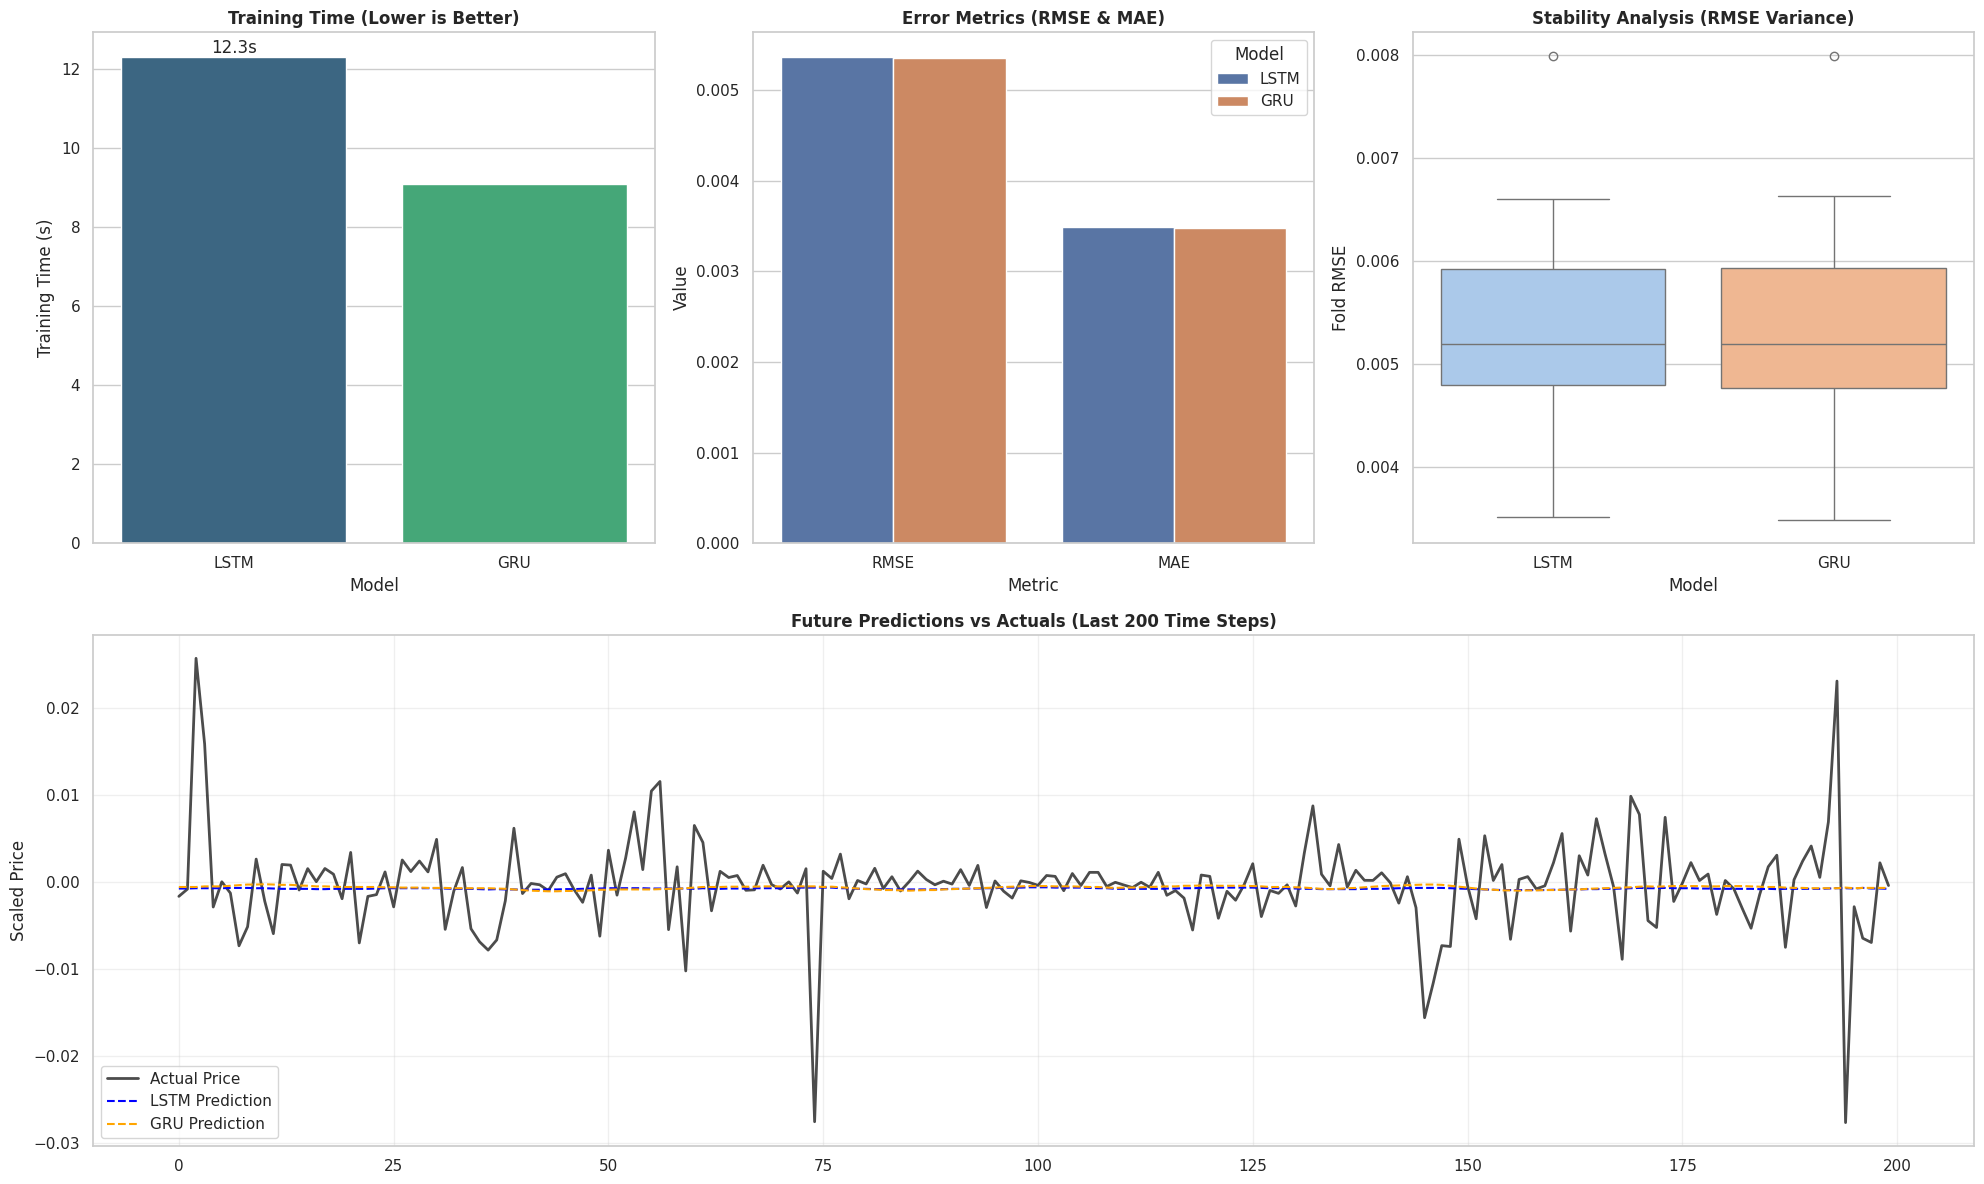


################################################################################
📊 DETAILED COMPARISON: BTCUSDT - 4h
################################################################################


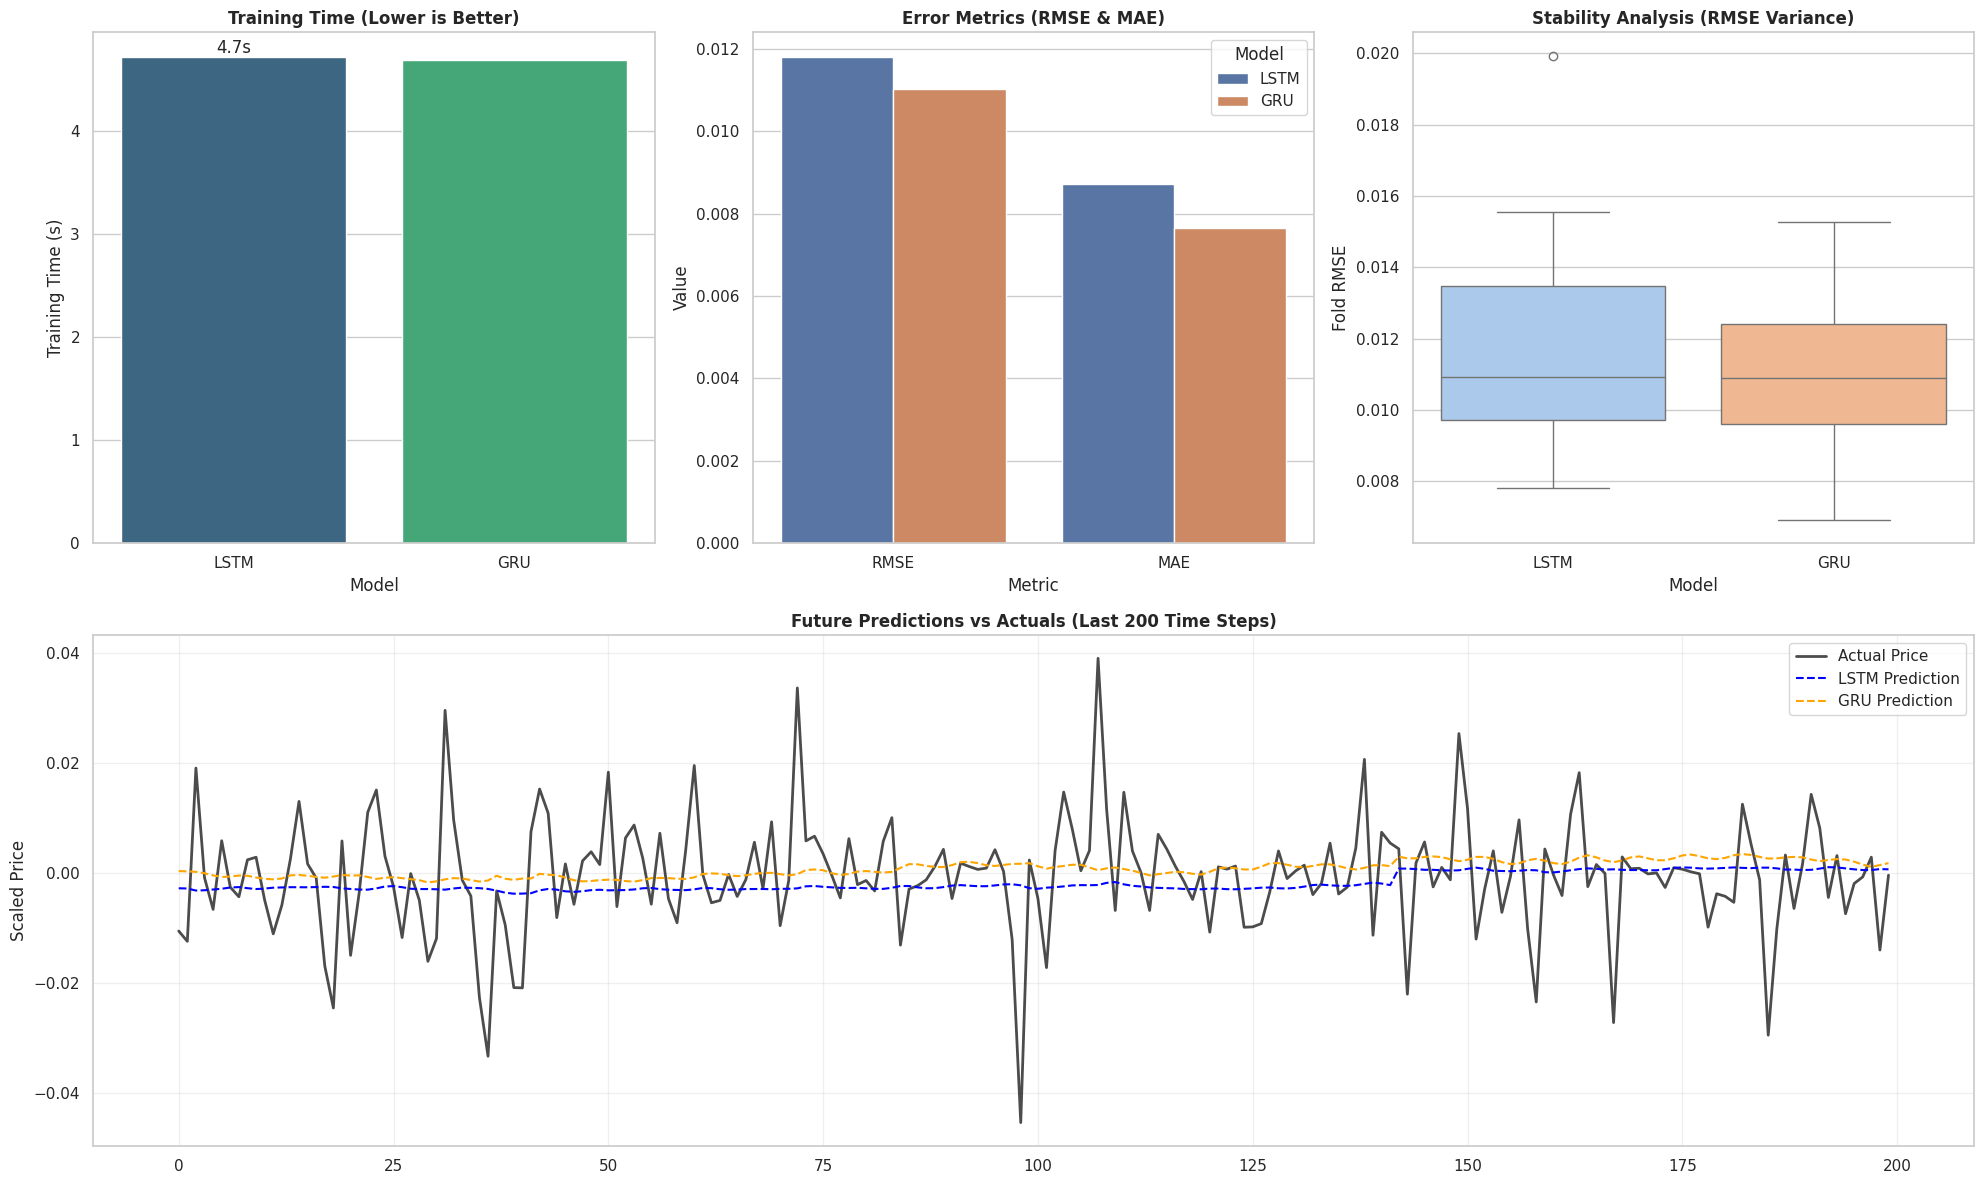


################################################################################
📊 DETAILED COMPARISON: BTCUSDT - 24h
################################################################################


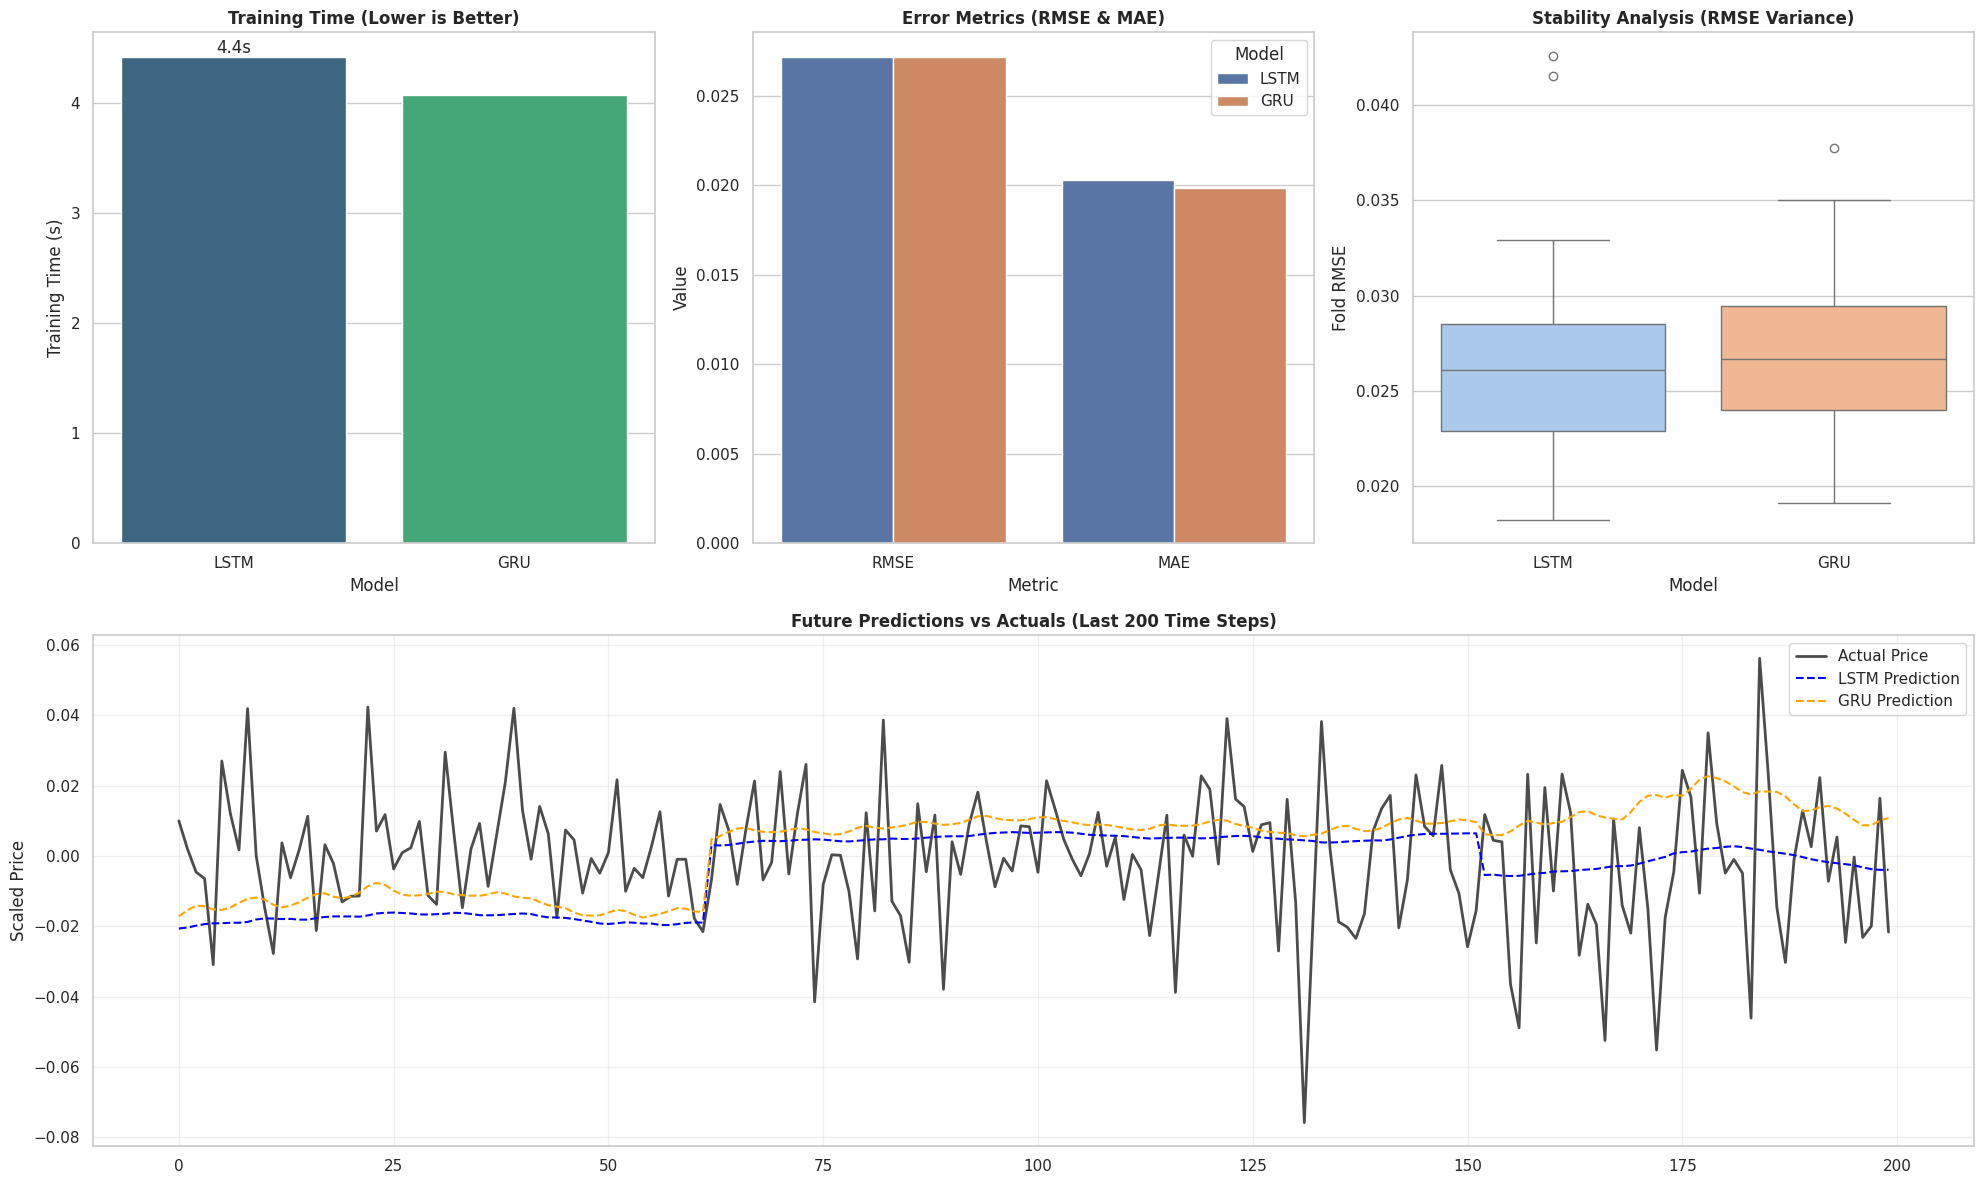


################################################################################
📊 DETAILED COMPARISON: ETHUSDT - 1h
################################################################################


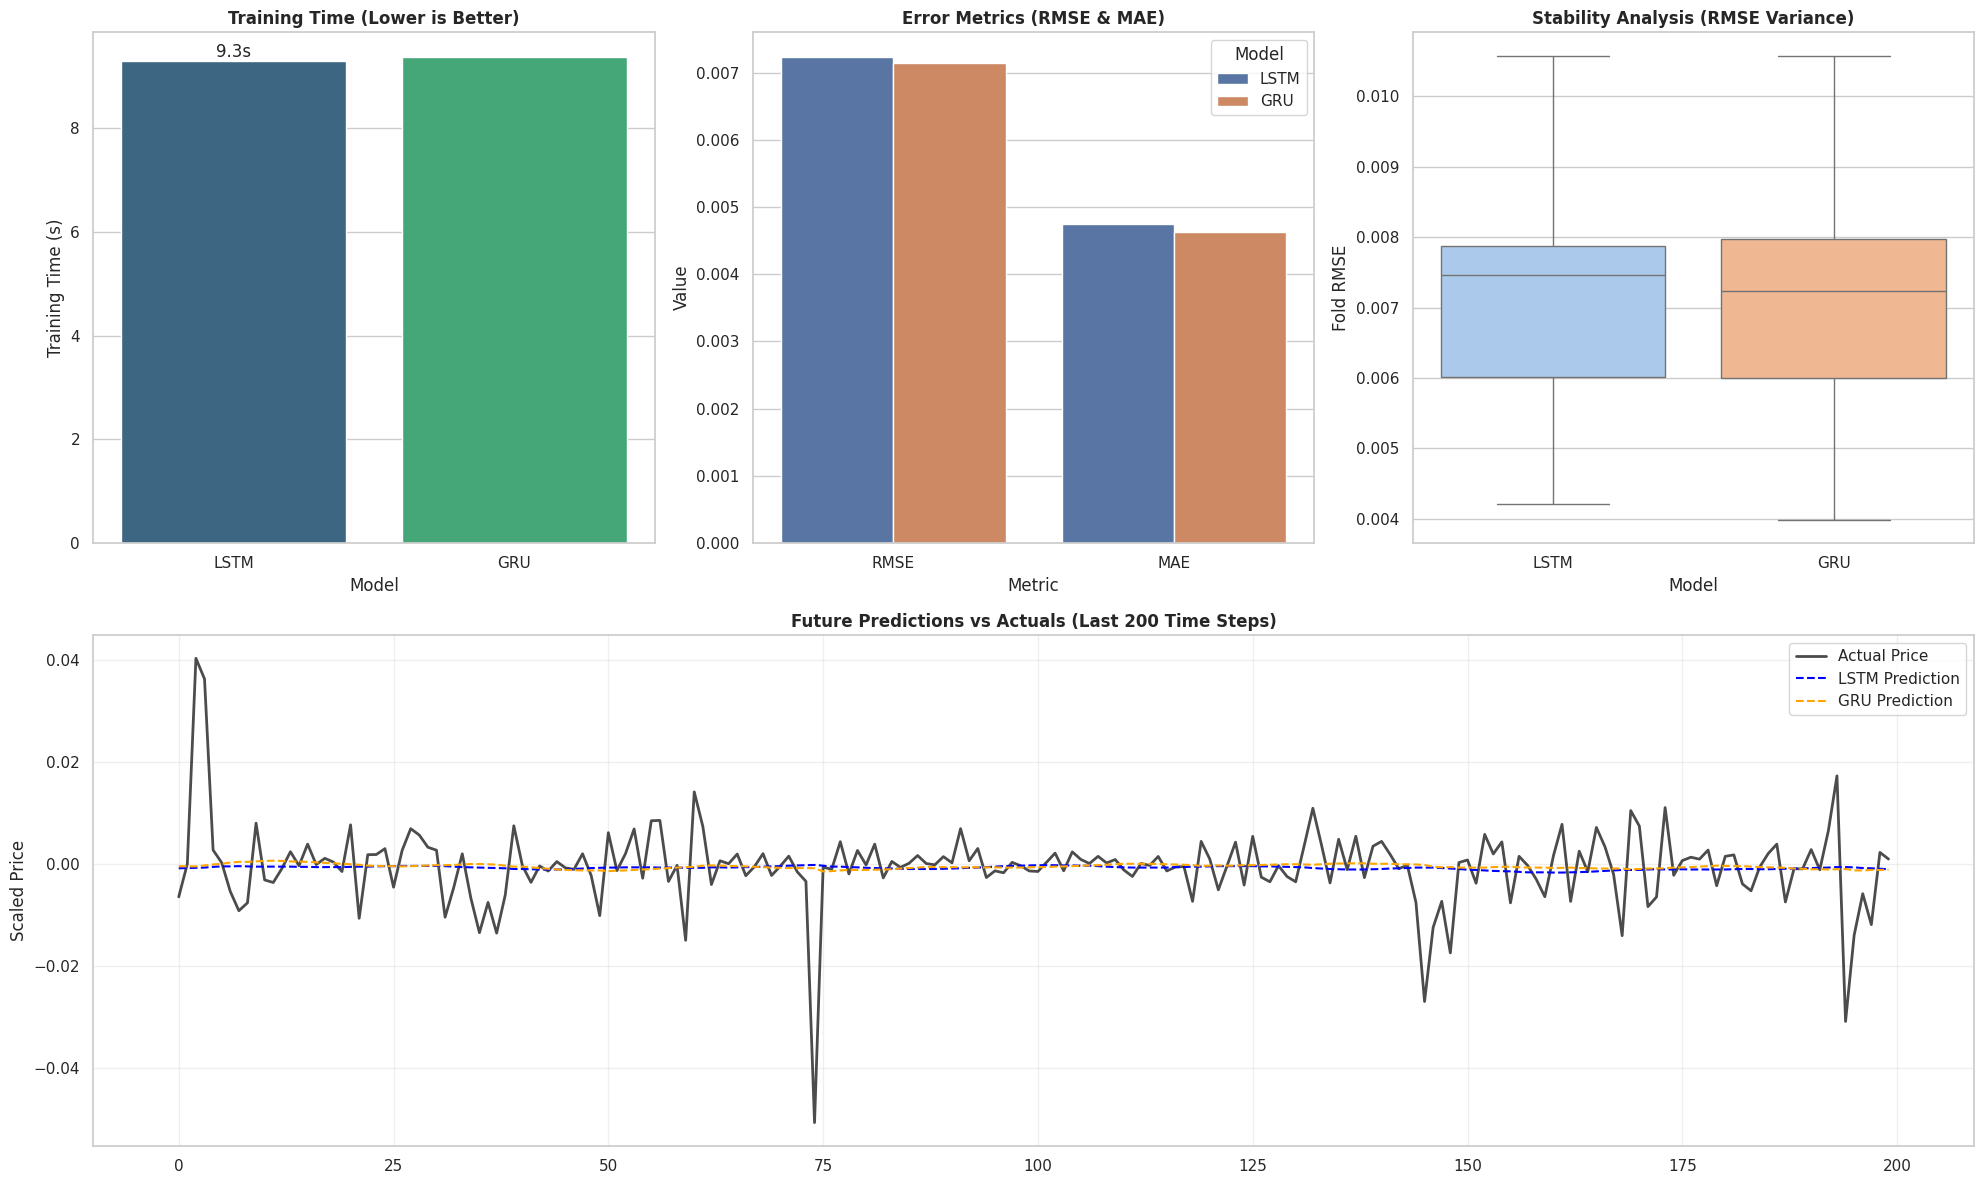


################################################################################
📊 DETAILED COMPARISON: ETHUSDT - 4h
################################################################################


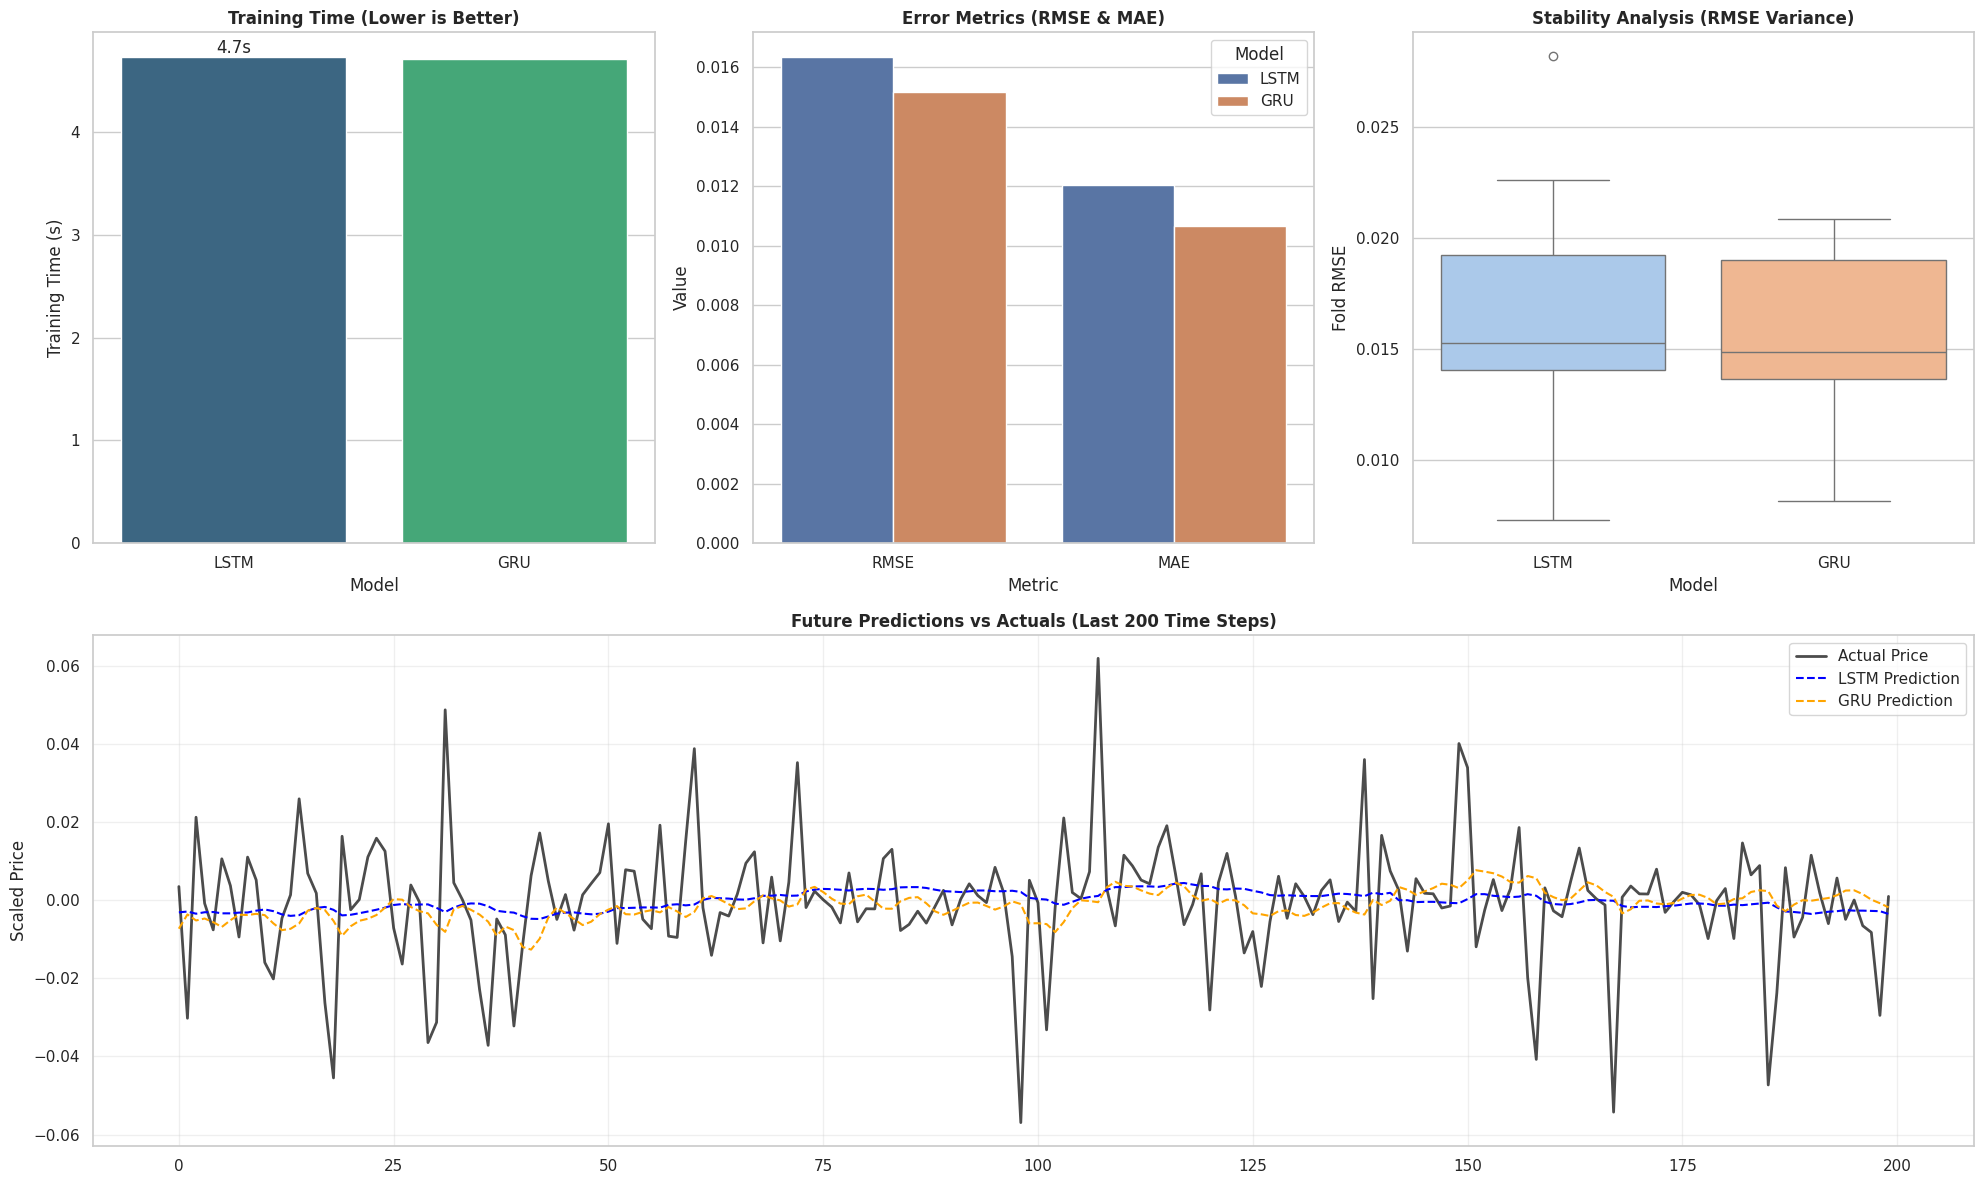


################################################################################
📊 DETAILED COMPARISON: ETHUSDT - 24h
################################################################################


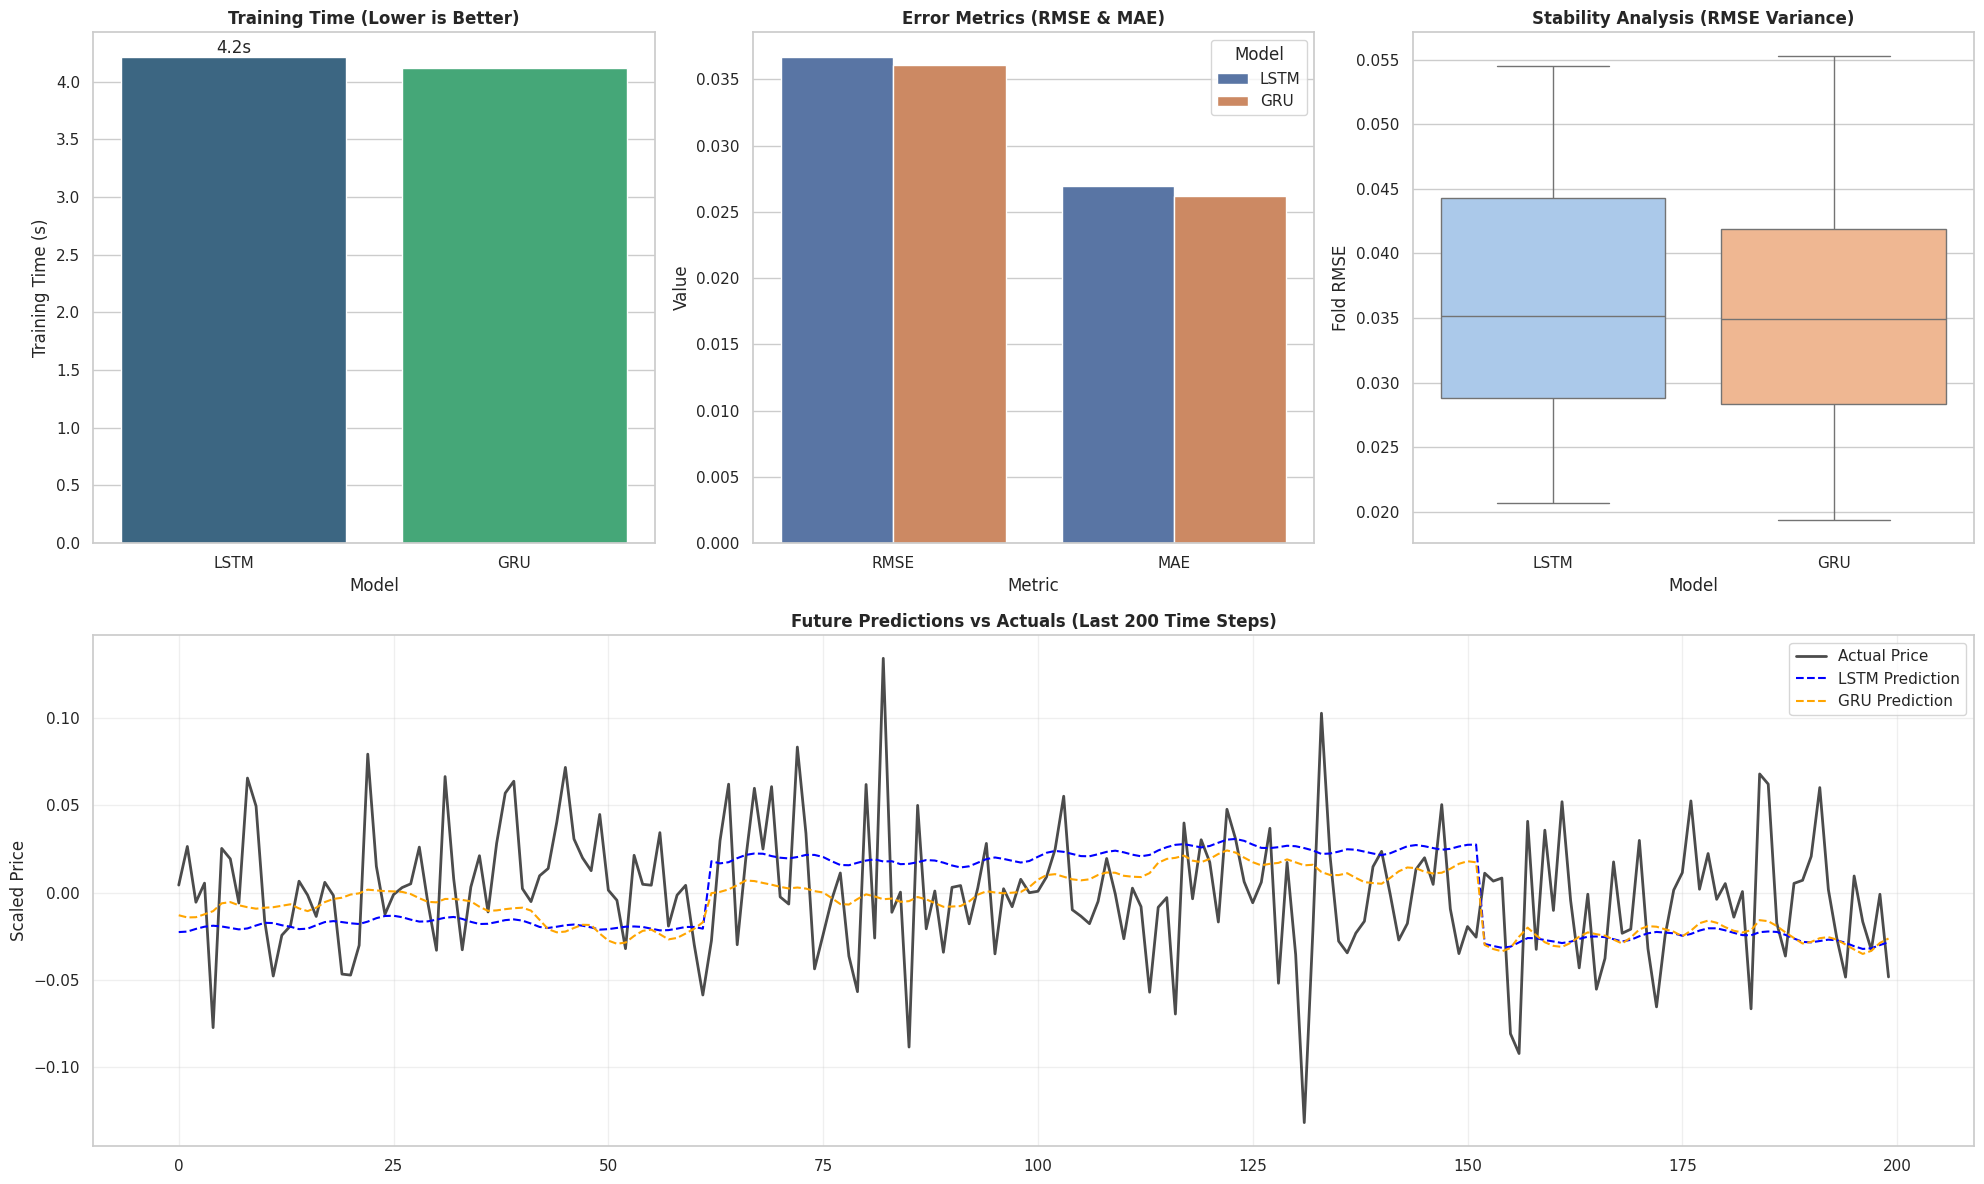


################################################################################
📊 DETAILED COMPARISON: LTCUSDT - 1h
################################################################################


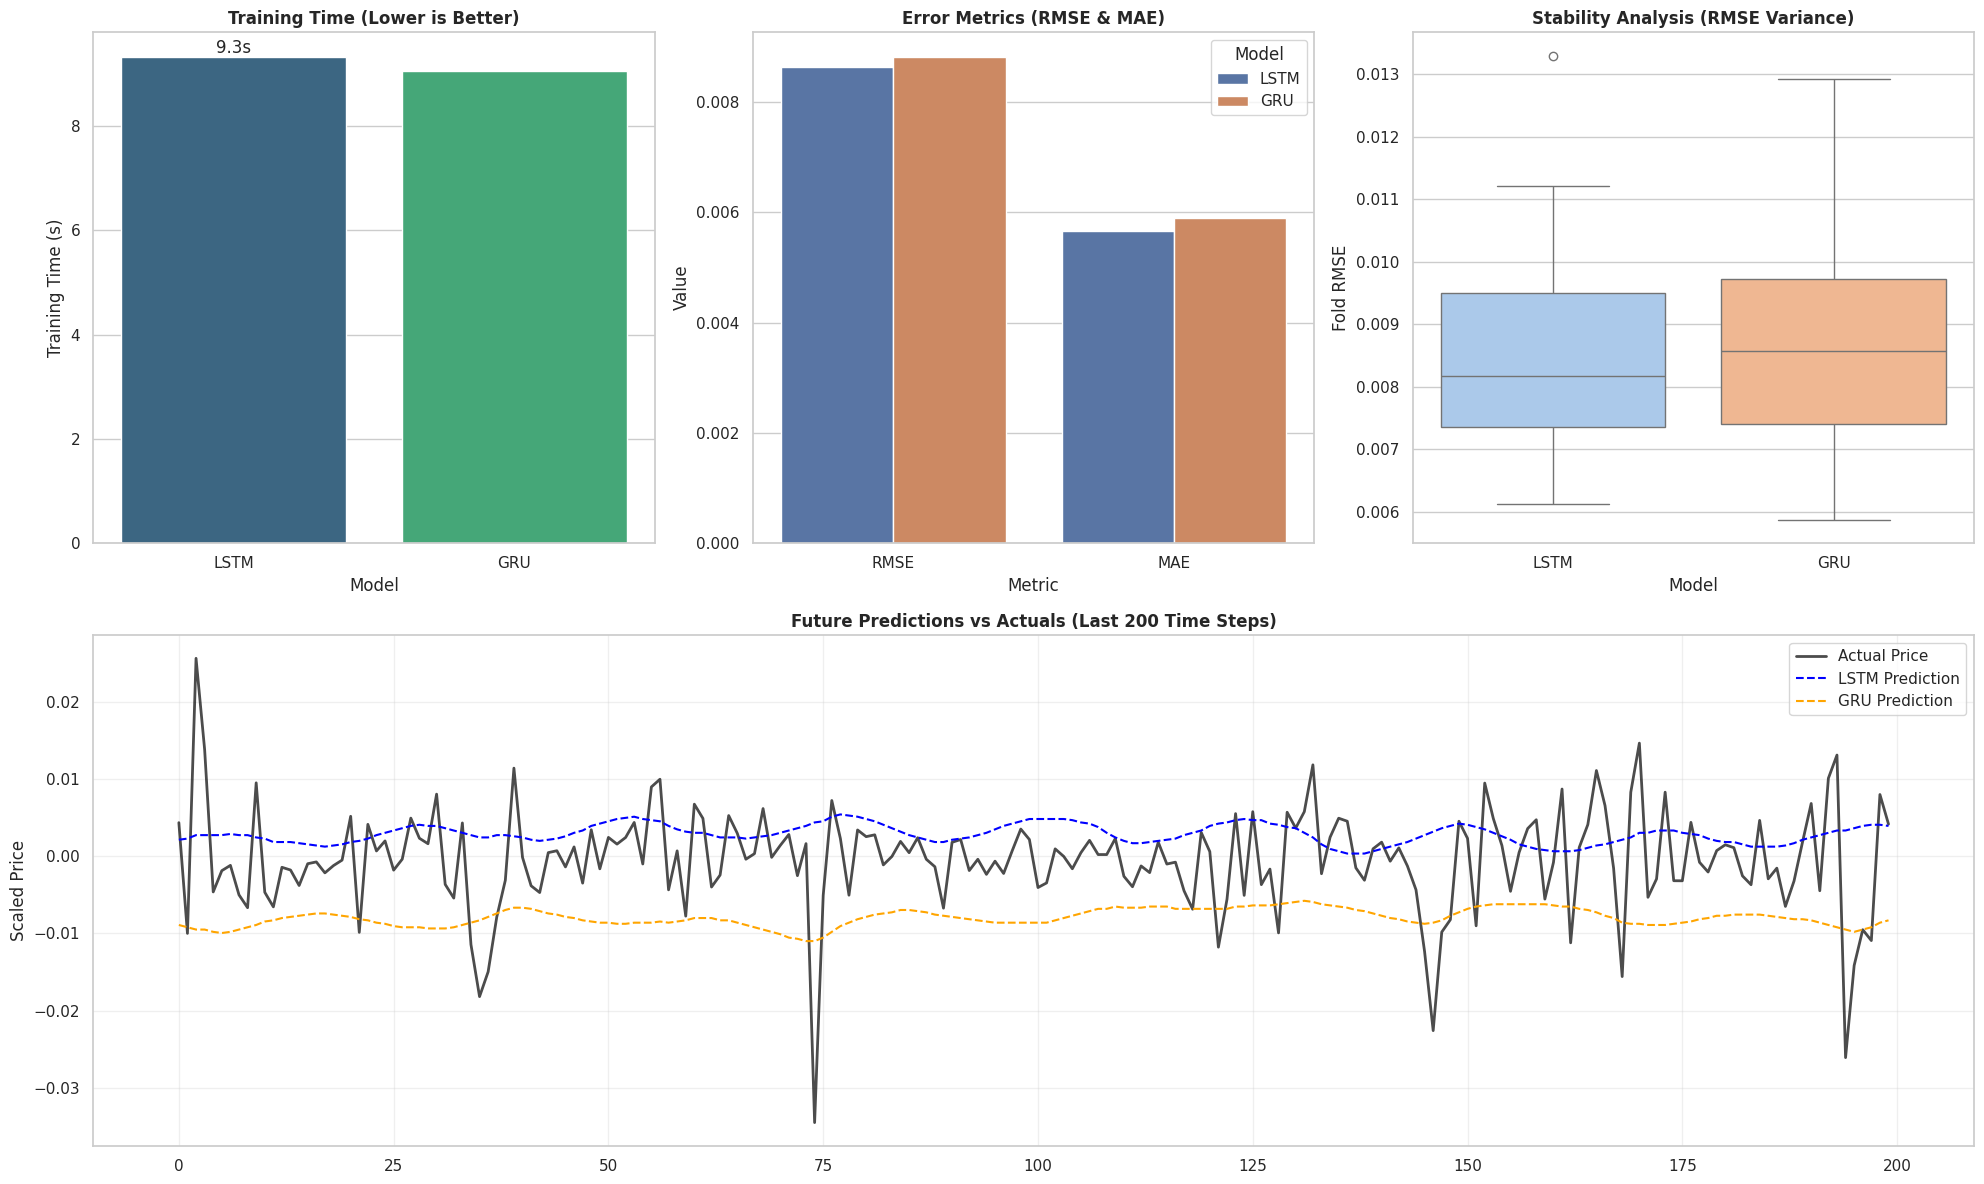


################################################################################
📊 DETAILED COMPARISON: LTCUSDT - 4h
################################################################################


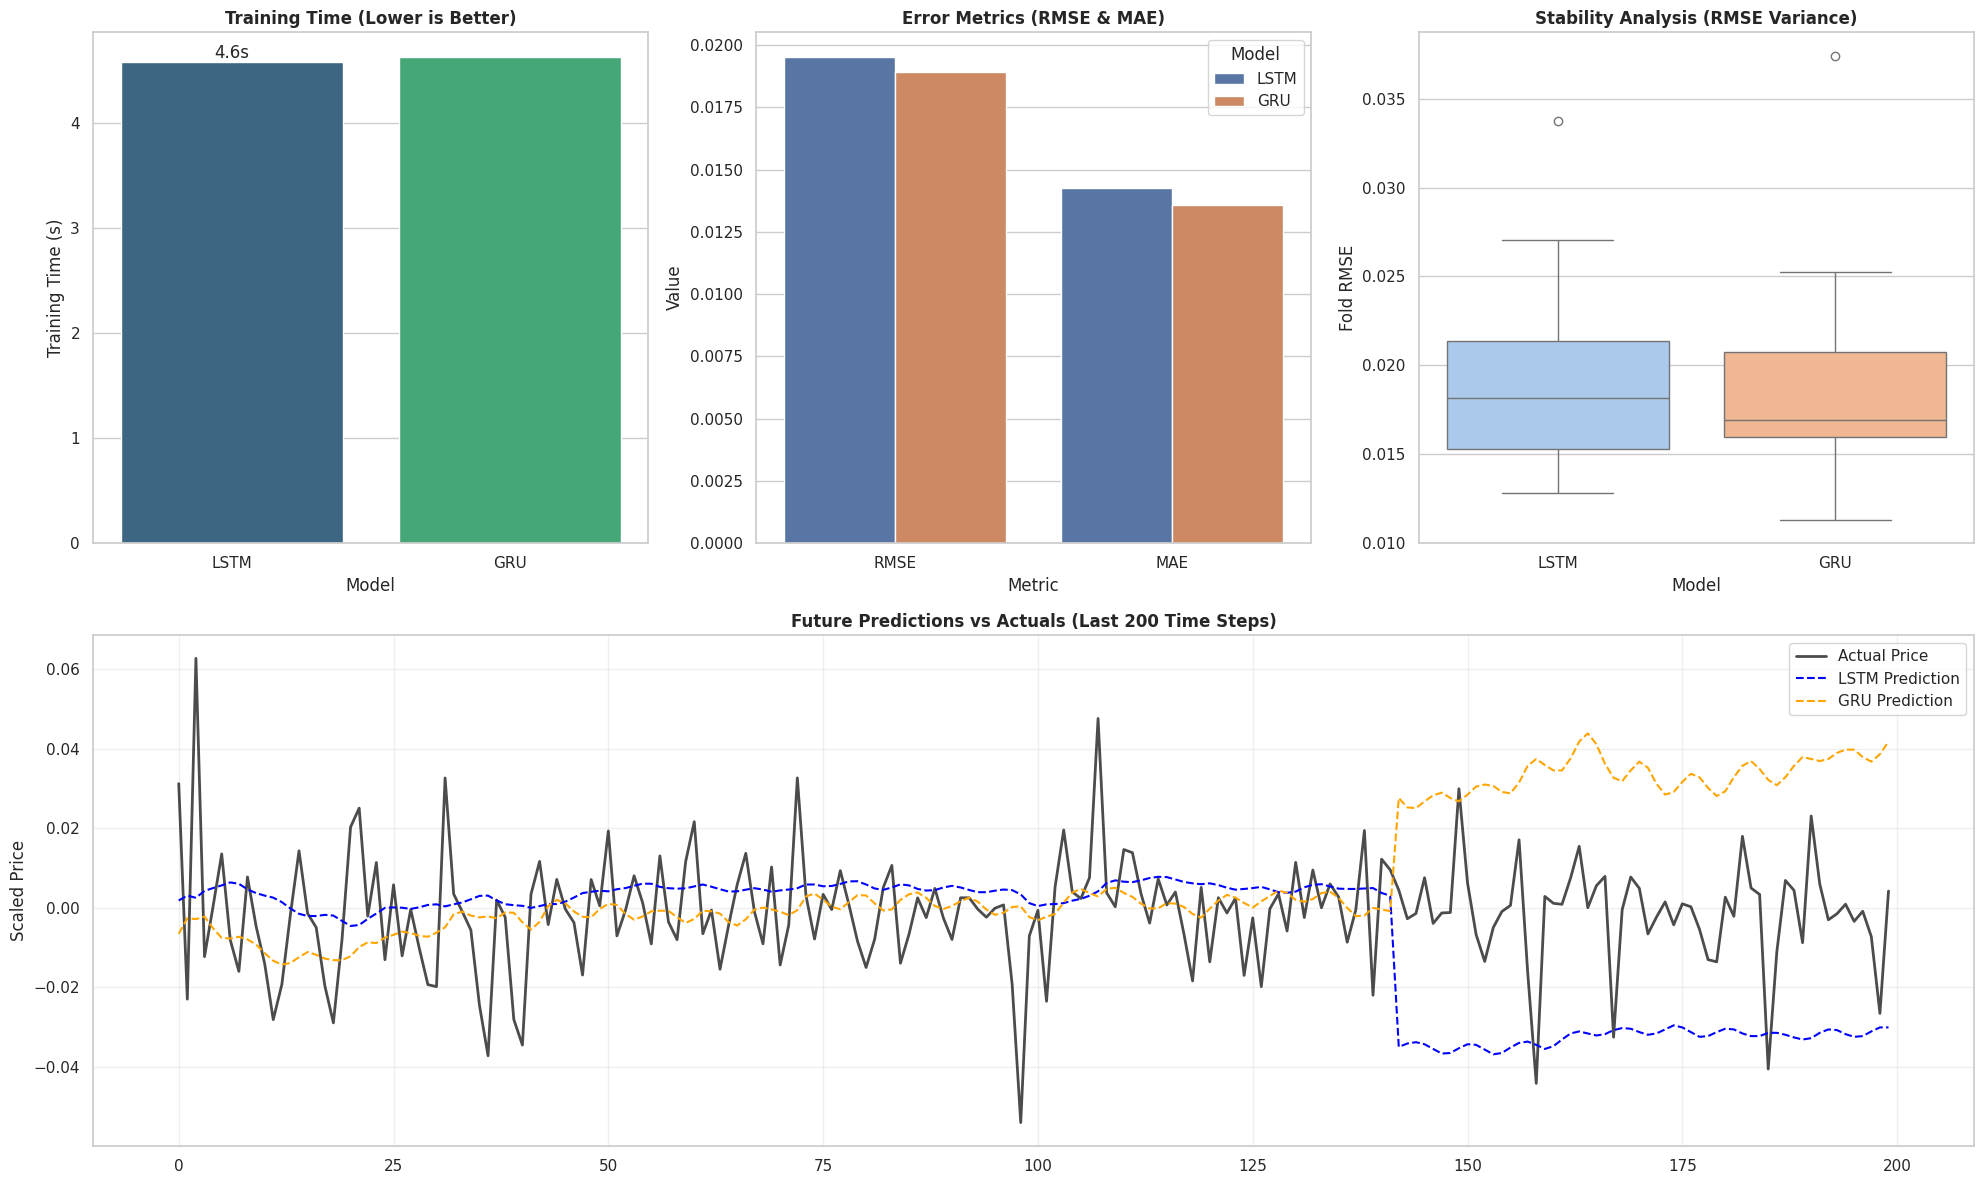


################################################################################
📊 DETAILED COMPARISON: LTCUSDT - 24h
################################################################################


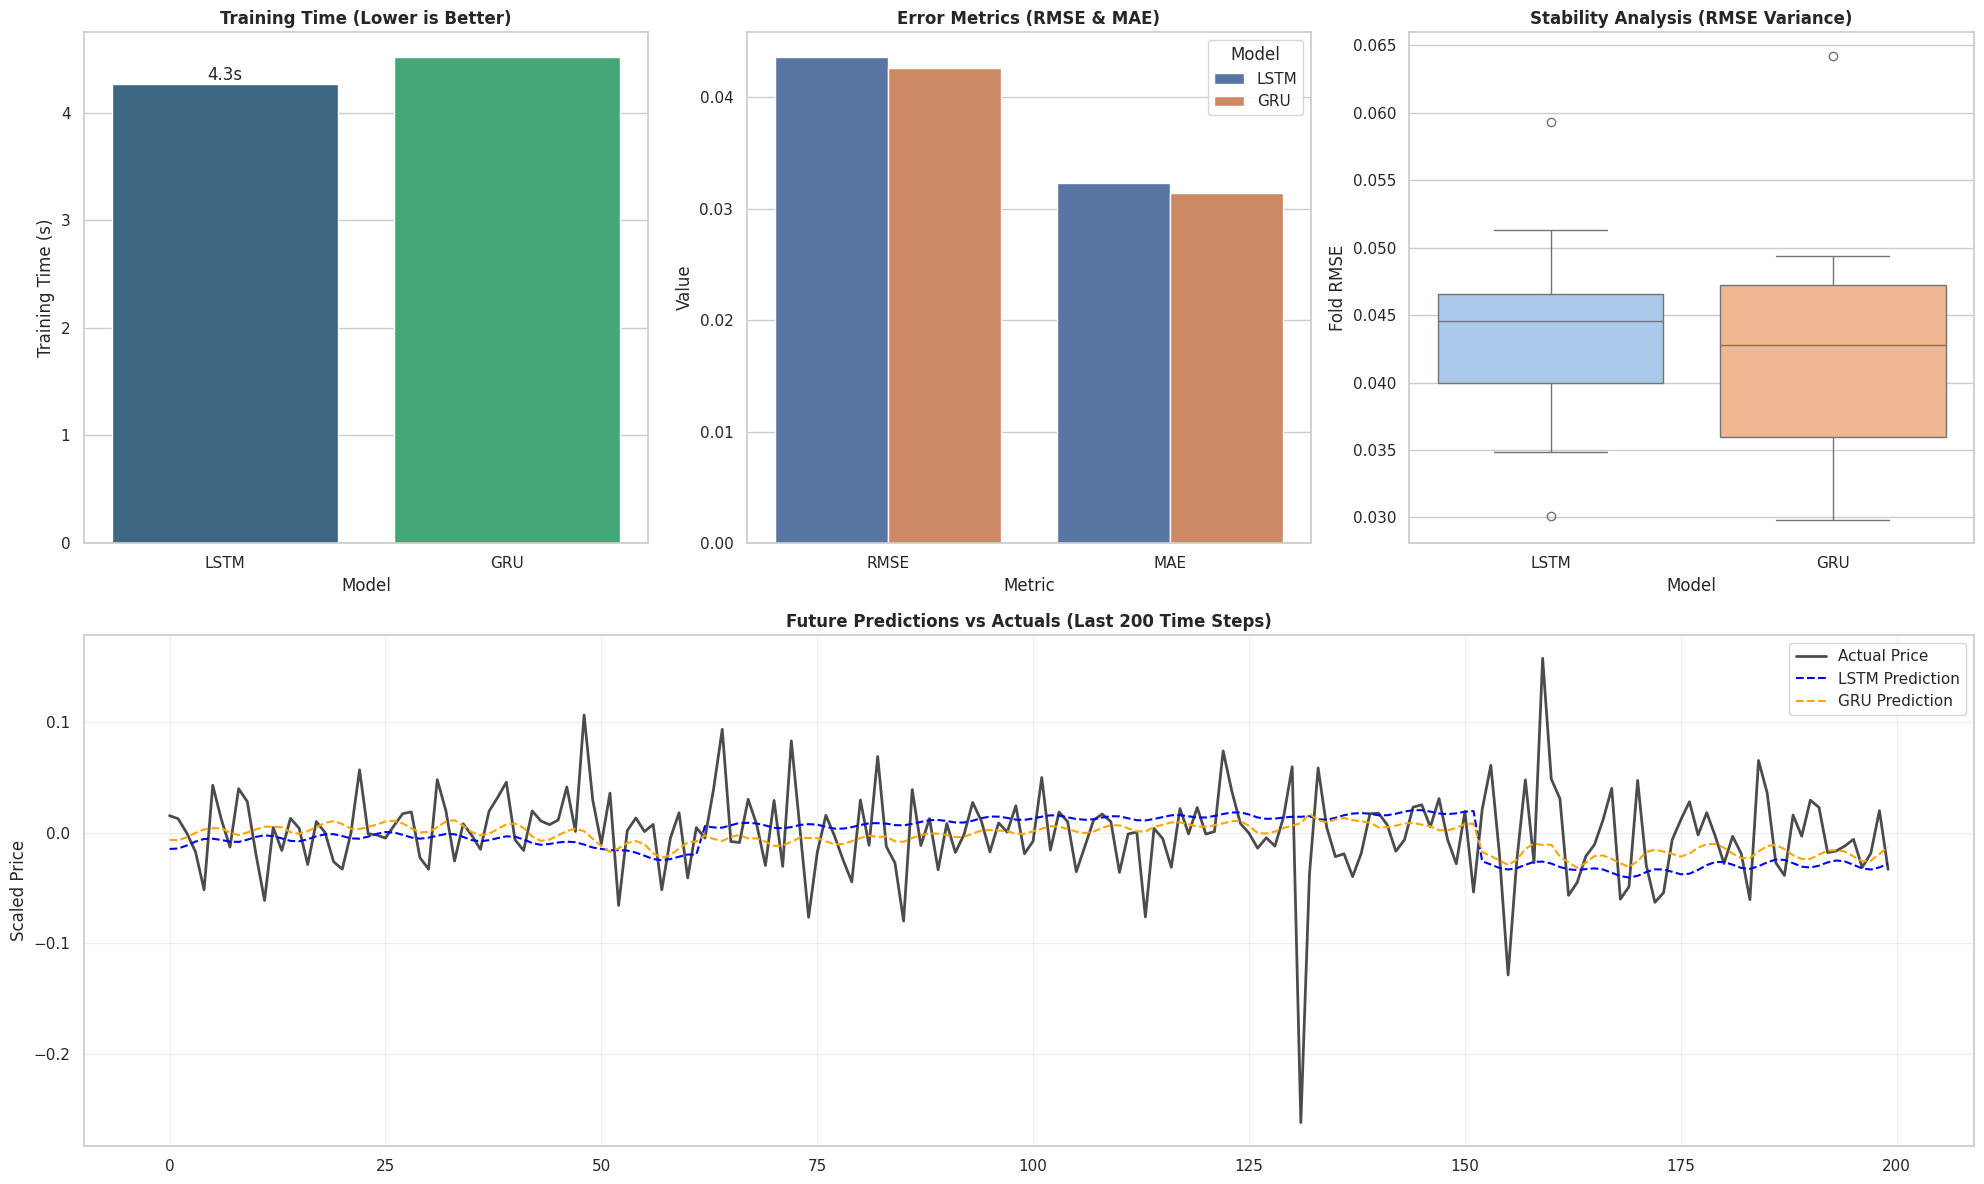

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_model_comparison(full_stats_df, detailed_results):
    sns.set_theme(style="whitegrid")
    
    # --- FIX 1: DETECT CORRECT TIME COLUMN ---
    # This prevents the ValueError if the column is named 'Time(s)' instead of 'Training Time (s)'
    if 'Time(s)' in full_stats_df.columns:
        time_col = 'Time(s)'
    elif 'Training Time (s)' in full_stats_df.columns:
        time_col = 'Training Time (s)'
    else:
        print(f"⚠️ Error: Could not find Time column. Columns are: {full_stats_df.columns.tolist()}")
        return

    # Get unique views
    cryptos = full_stats_df['Crypto'].unique()
    horizons = full_stats_df['Horizon'].unique()
    
    for crypto in cryptos:
        for horizon in horizons:
            subset = full_stats_df[(full_stats_df['Crypto'] == crypto) & (full_stats_df['Horizon'] == horizon)]
            if subset.empty: continue
            
            print(f"\n{'#'*80}\n📊 DETAILED COMPARISON: {crypto} - {horizon}\n{'#'*80}")
            
            fig = plt.figure(figsize=(20, 12))
            gs = fig.add_gridspec(2, 3)
            
            # 1. Training Time Comparison (Bar Plot)
            ax1 = fig.add_subplot(gs[0, 0])
            # --- FIX 2: Added hue='Model' and legend=False to fix FutureWarning ---
            sns.barplot(data=subset, x='Model', y=time_col, hue='Model', legend=False, palette='viridis', ax=ax1)
            ax1.set_title(f'Training Time (Lower is Better)', fontweight='bold')
            ax1.bar_label(ax1.containers[0], fmt='%.1fs')

            # 2. Metrics Comparison (Grouped Bar Plot)
            ax2 = fig.add_subplot(gs[0, 1])
            metrics_melt = subset.melt(id_vars=['Model'], value_vars=['RMSE', 'MAE'], var_name='Metric', value_name='Value')
            sns.barplot(data=metrics_melt, x='Metric', y='Value', hue='Model', palette='deep', ax=ax2)
            ax2.set_title('Error Metrics (RMSE & MAE)', fontweight='bold')
            
            # 3. Error Distribution (Box Plot across folds)
            ax3 = fig.add_subplot(gs[0, 2])
            rmse_dist = []
            for m in ['LSTM', 'GRU']:
                if m in detailed_results[crypto][horizon]:
                    folds = detailed_results[crypto][horizon][m]
                    for f in folds:
                        rmse_dist.append({'Model': m, 'Fold RMSE': f['rmse']})
            if rmse_dist:
                # --- FIX 3: Added hue='Model' and legend=False to fix FutureWarning ---
                sns.boxplot(data=pd.DataFrame(rmse_dist), x='Model', y='Fold RMSE', hue='Model', legend=False, palette='pastel', ax=ax3)
                ax3.set_title('Stability Analysis (RMSE Variance)', fontweight='bold')

            # 4. Future Predictions Comparison (Line Plot)
            ax4 = fig.add_subplot(gs[1, :]) # Spans entire bottom row
            
            # Stitch predictions together
            lstm_preds, gru_preds, actuals = [], [], []
            
            # Use the last 200 points for clear visualization
            try:
                if 'LSTM' in detailed_results[crypto][horizon]:
                    # Concatenate all fold predictions
                    all_lstm = np.concatenate([f['preds'] for f in detailed_results[crypto][horizon][ 'LSTM']])
                    all_actuals = np.concatenate([f['actuals'] for f in detailed_results[crypto][horizon]['LSTM']])
                    
                    # Take tail
                    plot_len = min(200, len(all_lstm))
                    lstm_preds = all_lstm[-plot_len:]
                    actuals = all_actuals[-plot_len:]
                
                if 'GRU' in detailed_results[crypto][horizon]:
                    all_gru = np.concatenate([f['preds'] for f in detailed_results[crypto][horizon]['GRU']])
                    plot_len = min(200, len(all_gru))
                    gru_preds = all_gru[-plot_len:]
                    
                # Plot
                ax4.plot(actuals, label='Actual Price', color='black', linewidth=2, alpha=0.7)
                if len(lstm_preds) > 0:
                    ax4.plot(lstm_preds, label='LSTM Prediction', linestyle='--', color='blue')
                if len(gru_preds) > 0:
                    ax4.plot(gru_preds, label='GRU Prediction', linestyle='--', color='orange')
                
                ax4.set_title(f'Future Predictions vs Actuals (Last {len(actuals)} Time Steps)', fontweight='bold')
                ax4.legend()
                ax4.set_ylabel('Scaled Price')
                ax4.grid(True, alpha=0.3)
                
            except Exception as e:
                ax4.text(0.5, 0.5, f"Could not plot predictions: {str(e)}", ha='center')

            plt.tight_layout()
            plt.show()

# --- EXECUTE VISUALIZATION ---
plot_model_comparison(results_df, model_results)

In [28]:
import pandas as pd

def generate_insights_dashboard(df):
    """
    Generates a simple, readable dashboard from the full stats.
    """
    # 1. Create Comparative DataFrame
    insights = []
    
    # Group by Crypto/Horizon
    groups = df.groupby(['Crypto', 'Horizon'])
    
    for (crypto, horizon), group in groups:
        # Check if we have both models to compare
        if len(group) < 2:
            continue
            
        lstm = group[group['Model'] == 'LSTM'].iloc[0]
        gru = group[group['Model'] == 'GRU'].iloc[0]
        
        # Determine Winners
        rmse_winner = "LSTM" if lstm['RMSE'] < gru['RMSE'] else "GRU"
        # Keep as float for gradient calculation
        rmse_diff = abs(lstm['RMSE'] - gru['RMSE']) / max(lstm['RMSE'], gru['RMSE']) * 100
        
        time_winner = "LSTM" if lstm['Training Time (s)'] < gru['Training Time (s)'] else "GRU"
        # Keep as float for gradient calculation
        time_diff = abs(lstm['Training Time (s)'] - gru['Training Time (s)'])/ max(lstm['Training Time (s)'], gru['Training Time (s)']) * 100
        
        insights.append({
            'Asset': f"{crypto} ({horizon})",
            'Best Accuracy': rmse_winner,
            'Accuracy Gain': rmse_diff,      # Float (for gradient)
            'Fastest Model': time_winner,
            'Speed Gain': time_diff,          # Float (for gradient)
            'LSTM RMSE': lstm['RMSE'],        # Float
            'GRU RMSE': gru['RMSE'],          # Float
            'Verdict': rmse_winner 
        })
        
    insights_df = pd.DataFrame(insights)
    
    # 2. Display Dashboard
    print("\n" + "="*80)
    print("🏆 FINAL COMPARATIVE SCORECARD 🏆")
    print("="*80)
    
    # Styling the DataFrame for display
    # 1. background_gradient works now because columns are floats
    # 2. format() adds the '%' symbol and precision ONLY for display
    # 3. map() replaces the deprecated applymap()
    styled_df = (insights_df.style
                 .background_gradient(cmap='Blues', subset=['Accuracy Gain', 'Speed Gain'])
                 .format({
                     'Accuracy Gain': '{:.2f}%', 
                     'Speed Gain': '{:.2f}%',
                     'LSTM RMSE': '{:.5f}',
                     'GRU RMSE': '{:.5f}'
                 })
                 .map(lambda x: 'font-weight: bold; color: green' if x == 'LSTM' else '', subset=['Best Accuracy', 'Fastest Model'])
                 .map(lambda x: 'font-weight: bold; color: orange' if x == 'GRU' else '', subset=['Best Accuracy', 'Fastest Model'])
                )
    
    display(styled_df)

    return insights_df

# --- RUN DASHBOARD ---
# Ensure 'results_df' has columns 'Time(s)' or 'Training Time (s)'
# Adjust the column name in the function above if it differs in your dataframe (e.g. 'Time(s)')
insights_df = generate_insights_dashboard(results_df)



🏆 FINAL COMPARATIVE SCORECARD 🏆


,Asset,Best Accuracy,Accuracy Gain,Fastest Model,Speed Gain,LSTM RMSE,GRU RMSE,Verdict
0,BTCUSDT (1h),GRU,0.26%,GRU,26.16%,0.00537,0.00536,GRU
1,BTCUSDT (24h),GRU,0.00%,GRU,7.95%,0.02719,0.02719,GRU
2,BTCUSDT (4h),GRU,6.58%,GRU,0.79%,0.01181,0.01103,GRU
3,ETHUSDT (1h),GRU,1.33%,LSTM,0.87%,0.00724,0.00714,GRU
4,ETHUSDT (24h),GRU,1.68%,GRU,2.35%,0.03671,0.03609,GRU
5,ETHUSDT (4h),GRU,7.24%,GRU,0.55%,0.01636,0.01517,GRU
6,LTCUSDT (1h),LSTM,2.19%,GRU,3.02%,0.00863,0.00883,LSTM
7,LTCUSDT (24h),GRU,2.34%,LSTM,5.65%,0.04363,0.04261,GRU
8,LTCUSDT (4h),GRU,3.15%,LSTM,1.05%,0.01954,0.01893,GRU


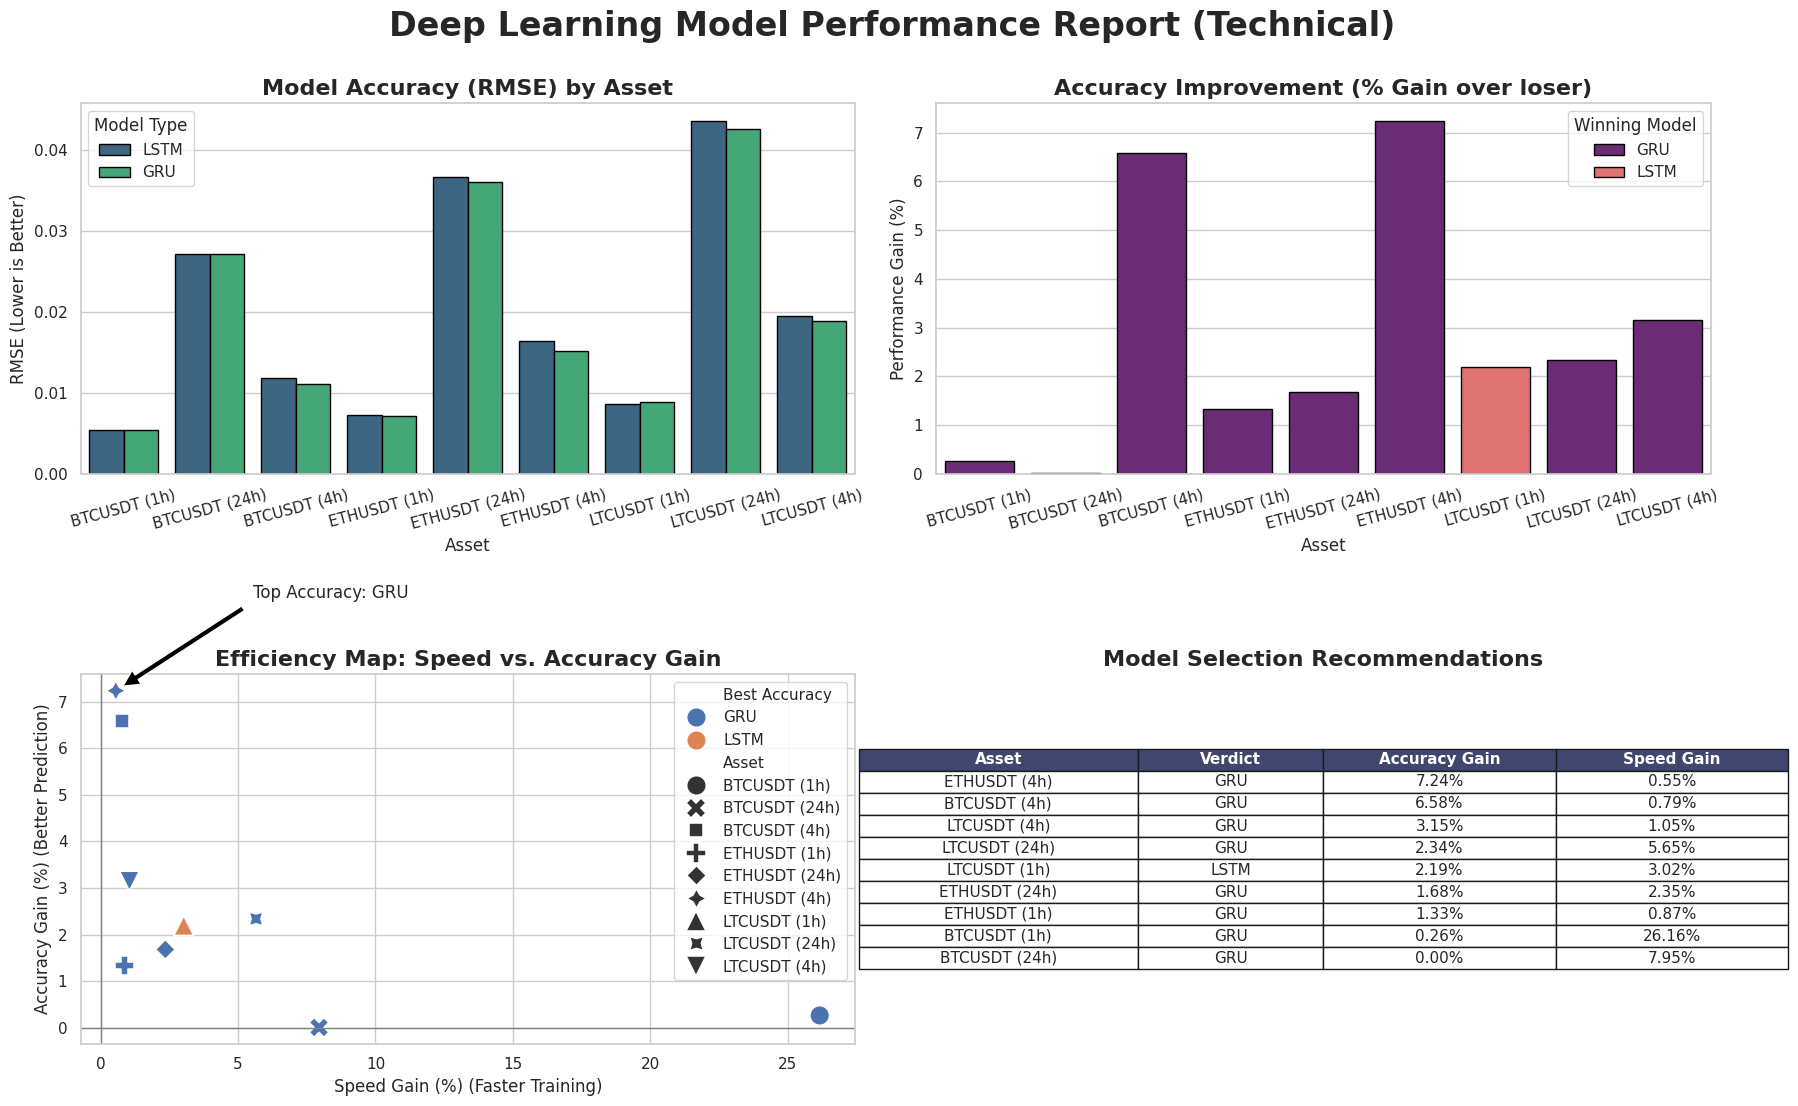

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def generate_technical_dashboard(insights_df):
    """
    Generates a 4-panel Technical Performance Report from the insights_df.
    Adapts the layout to show RMSE and Speed metrics.
    """
    # Set professional style
    sns.set_theme(style="whitegrid")
    
    # Initialize the layout (2x2 Grid)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Deep Learning Model Performance Report (Technical)', fontsize=24, fontweight='bold', y=0.95)
    
    # --- PANEL 1: Model Accuracy Comparison (RMSE) ---
    # Goal: Compare absolute error side-by-side
    
    # Transform data for plotting (Wide to Long)
    rmse_data = insights_df.melt(id_vars=['Asset'], 
                                 value_vars=['LSTM RMSE', 'GRU RMSE'], 
                                 var_name='Model', 
                                 value_name='RMSE')
    # Clean up model names for legend (remove " RMSE")
    rmse_data['Model'] = rmse_data['Model'].str.replace(' RMSE', '')

    sns.barplot(data=rmse_data, x='Asset', y='RMSE', hue='Model', 
                palette='viridis', ax=axes[0, 0], edgecolor='black')
    
    axes[0, 0].set_title('Model Accuracy (RMSE) by Asset', fontsize=16, fontweight='bold')
    axes[0, 0].set_ylabel('RMSE (Lower is Better)', fontsize=12)
    axes[0, 0].legend(title='Model Type')
    axes[0, 0].tick_params(axis='x', rotation=15) # Rotate labels if many assets

    # --- PANEL 2: Accuracy Gain (%) ---
    # Goal: Show how much better the winner is compared to the loser
    sns.barplot(data=insights_df, x='Asset', y='Accuracy Gain', hue='Best Accuracy', 
                palette='magma', ax=axes[0, 1], edgecolor='black')
    
    axes[0, 1].set_title('Accuracy Improvement (% Gain over loser)', fontsize=16, fontweight='bold')
    axes[0, 1].set_ylabel('Performance Gain (%)', fontsize=12)
    axes[0, 1].legend(title='Winning Model', loc='upper right')
    axes[0, 1].tick_params(axis='x', rotation=15)

    # --- PANEL 3: Computational Speed Gain ---
    # Goal: Show which model trains faster and by how much
    sns.scatterplot(data=insights_df, x='Speed Gain', y='Accuracy Gain', hue='Best Accuracy', style='Asset',
                    s=200, ax=axes[1, 0], palette='deep')
    
    axes[1, 0].set_title('Efficiency Map: Speed vs. Accuracy Gain', fontsize=16, fontweight='bold')
    axes[1, 0].set_xlabel('Speed Gain (%) (Faster Training)', fontsize=12)
    axes[1, 0].set_ylabel('Accuracy Gain (%) (Better Prediction)', fontsize=12)
    
    # Add quadrants/lines
    axes[1, 0].axhline(0, color='grey', linewidth=1)
    axes[1, 0].axvline(0, color='grey', linewidth=1)
    
    # Annotate the most efficient win
    best_row = insights_df.loc[insights_df['Accuracy Gain'].idxmax()]
    axes[1, 0].annotate(f"Top Accuracy: {best_row['Best Accuracy']}", 
                        (best_row['Speed Gain'], best_row['Accuracy Gain']),
                        xytext=(best_row['Speed Gain']+5, best_row['Accuracy Gain']+2),
                        arrowprops=dict(facecolor='black', shrink=0.05))

    # --- PANEL 4: Final Recommendation Table ---
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Model Selection Recommendations', fontsize=16, fontweight='bold')
    
    # Prepare Data for Table
    table_cols = ['Asset', 'Verdict', 'Accuracy Gain', 'Speed Gain']
    table_data = insights_df[table_cols].sort_values(by='Accuracy Gain', ascending=False)
    
    # Apply Formatting
    table_data['Accuracy Gain'] = table_data['Accuracy Gain'].map('{:,.2f}%'.format)
    table_data['Speed Gain'] = table_data['Speed Gain'].map('{:,.2f}%'.format)
    
    # Create Table
    table = axes[1, 1].table(
        cellText=table_data.values,
        colLabels=table_data.columns,
        loc='center',
        cellLoc='center',
        colWidths=[0.3, 0.2, 0.25, 0.25]
    )
    
    # Styling
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.5)
    
    # Bold Headers
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#40466e') # Professional dark blue header

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- EXECUTE DASHBOARD ---
if 'insights_df' in locals() and not insights_df.empty:
    generate_technical_dashboard(insights_df)
else:
    print("⚠️ 'insights_df' not found. Please run 'generate_insights_dashboard' first.")

In [30]:
import pandas as pd
import numpy as np

# --- HELPER: FINANCIAL METRICS CALCULATOR ---
def calculate_financial_metrics(returns_series, fee_per_trade=0.001, trades_count=0):
    """
    Computes professional metrics for a series of strategy returns.
    """
    # 1. Net Returns (Approximate deduction of fees from total return)
    total_fees = trades_count * fee_per_trade
    net_total_return = returns_series.sum() - total_fees
    
    # 2. Cumulative Return (Equity Curve)
    equity_curve = np.exp(returns_series.cumsum())
    
    # 3. ROI
    if len(equity_curve) > 0:
        roi_pct = (equity_curve.iloc[-1] - 1) * 100
    else:
        roi_pct = 0.0
    
    # 4. Max Drawdown
    peak = equity_curve.cummax()
    drawdown = (equity_curve - peak) / peak
    if len(drawdown) > 0:
        max_dd_pct = drawdown.min() * 100
    else:
        max_dd_pct = 0.0
    
    # 5. Sharpe Ratio (Annualized)
    # Assuming hourly data (24*365 = 8760 periods)
    avg_ret = returns_series.mean()
    std_ret = returns_series.std()
    
    if std_ret == 0 or np.isnan(std_ret):
        sharpe = 0.0
    else:
        ann_factor = np.sqrt(365 * 24) 
        sharpe = (avg_ret / std_ret) * ann_factor

    return {
        'ROI (%)': roi_pct,
        'Max Drawdown (%)': max_dd_pct,
        'Sharpe Ratio': sharpe,
        'Trades': trades_count
    }, equity_curve

In [31]:

# --- MAIN COMPARISON FUNCTION ---
def compare_all_models(final_views, sma_results, xgb_results, dl_results, experiment_summary):
    """
    Unifies SMA, XGBoost, and the Best DL Model into one leaderboard DataFrame.
    Returns: pd.DataFrame
    """
    master_scorecard = []
    
    print(f"{'='*80}")
    print(f"{'CRYPTO':<8} | {'HORIZON':<6} | {'MODEL':<10} | {'ROI':<8} | {'DD':<8} | {'SHARPE':<6} | {'TRADES'}")
    print(f"{'='*80}")

    for crypto in final_views.keys():
        for horizon in final_views[crypto].keys():
            
            # --- 1. SMA EVALUATION ---
            if crypto in sma_results and horizon in sma_results[crypto]:
                sma_df = sma_results[crypto][horizon]
                
                # Extract Strategy Returns
                sma_rets = sma_df['Strategy_Return']
                trades = sma_df['Position'].diff().abs().fillna(0).sum()
                
                metrics, _ = calculate_financial_metrics(sma_rets, trades_count=trades)
                
                print(f"{crypto:<8} | {horizon:<6} | {'SMA':<10} | {metrics['ROI (%)']:>6.1f}% | {metrics['Max Drawdown (%)']:>6.1f}% | {metrics['Sharpe Ratio']:>6.2f} | {metrics['Trades']}")
                
                master_scorecard.append({
                    'Crypto': crypto, 'Horizon': horizon, 'Model': 'SMA', 'SubModel': 'Simple',
                    **metrics
                })

            # --- 2. XGBOOST EVALUATION ---
            if crypto in xgb_results and horizon in xgb_results[crypto]:
                xgb_df = xgb_results[crypto][horizon]
                
                # Calculate XGB Returns (Shifted Position * Actual Return)
                xgb_pos = xgb_df['Position']
                xgb_actuals = xgb_df['Log_Returns']
                xgb_rets = xgb_pos.shift(1) * xgb_actuals
                
                trades = xgb_pos.diff().abs().sum()
                
                metrics, _ = calculate_financial_metrics(xgb_rets.dropna(), trades_count=trades)
                
                print(f"{crypto:<8} | {horizon:<6} | {'XGBoost':<10} | {metrics['ROI (%)']:>6.1f}% | {metrics['Max Drawdown (%)']:>6.1f}% | {metrics['Sharpe Ratio']:>6.2f} | {metrics['Trades']}")
                
                master_scorecard.append({
                    'Crypto': crypto, 'Horizon': horizon, 'Model': 'XGBoost', 'SubModel': 'Tree',
                    **metrics
                })

            # --- 3. DEEP LEARNING (CHAMPION) EVALUATION ---
            try:
                # Find the winner for this specific pair from experiment_summary
                row = experiment_summary[
                    (experiment_summary['Crypto'] == crypto) & 
                    (experiment_summary['Horizon'] == horizon)
                ]
                
                if not row.empty:
                    winner = row.iloc[0]['Winner'] # 'LSTM' or 'GRU'
                    
                    if winner in ['LSTM', 'GRU']:
                        # Get predictions
                        dl_data = dl_results[crypto][horizon][winner]
                        
                        all_preds = np.concatenate([fold['preds'] for fold in dl_data])
                        all_actuals = np.concatenate([fold['actuals'] for fold in dl_data])
                        
                        # Simulate Strategy (Long Only for fair comparison)
                        signals = np.where(all_preds > 0, 1, 0)
                        
                        dl_rets = pd.Series(signals * all_actuals)
                        trades = np.sum(np.abs(np.diff(signals, prepend=0)))
                        
                        metrics, _ = calculate_financial_metrics(dl_rets, trades_count=trades)
                        
                        model_label = f"DL-{winner}"
                        print(f"{crypto:<8} | {horizon:<6} | {model_label:<10} | {metrics['ROI (%)']:>6.1f}% | {metrics['Max Drawdown (%)']:>6.1f}% | {metrics['Sharpe Ratio']:>6.2f} | {metrics['Trades']}")
                        
                        master_scorecard.append({
                            'Crypto': crypto, 'Horizon': horizon, 'Model': 'DeepLearning',
                            'SubModel': winner,
                            **metrics
                        })
            except Exception as e:
                print(f"Skipping DL for {crypto}-{horizon}: {e}")

            print("-" * 80)

    # Convert to DataFrame and reorder columns for clarity
    df_results = pd.DataFrame(master_scorecard)
    if not df_results.empty:
        cols = ['Crypto', 'Horizon', 'Model', 'SubModel', 'ROI (%)', 'Max Drawdown (%)', 'Sharpe Ratio', 'Trades']
        df_results = df_results[cols]
        
    return df_results



In [32]:
# --- EXECUTE COMPARISON ---
# Make sure to pass the correct variables from your previous steps:
# results_df: The DataFrame returned by run_full_experiment (contains 'Winner')
# model_results: The dictionary returned by run_full_experiment (contains raw predictions)

if 'results_df' in locals() and 'model_results' in locals():
    final_scorecard = compare_all_models(final_views, sma_results, xgb_results, model_results, results_df)
    
    # print("\n✅ Final DataFrame Generated:")
    # display(final_scorecard)
else:
    print("⚠️ Missing input data. Ensure 'results_df' and 'model_results' are generated from Phase 4.")
    
final_scorecard.to_csv('analysis_data/ComparisonReport.csv')

CRYPTO   | HORIZON | MODEL      | ROI      | DD       | SHARPE | TRADES
BTCUSDT  | 1h     | SMA        |  -34.1% |  -36.5% |  -1.42 | 245.0
BTCUSDT  | 1h     | XGBoost    |  -17.5% |  -18.4% |  -1.45 | 326.0
BTCUSDT  | 1h     | DL-GRU     |   75.8% |  -32.7% |   0.45 | 438
--------------------------------------------------------------------------------
BTCUSDT  | 4h     | SMA        |   -6.2% |  -25.6% |  -0.46 | 60.0
BTCUSDT  | 4h     | XGBoost    |  -10.9% |  -19.8% |  -1.23 | 386.0
BTCUSDT  | 4h     | DL-GRU     |  -61.4% |  -65.0% |  -1.45 | 549
--------------------------------------------------------------------------------
BTCUSDT  | 24h    | SMA        |    6.2% |  -23.2% |   1.44 | 8.0
BTCUSDT  | 24h    | XGBoost    |   -9.0% |  -29.0% |  -1.80 | 156.0
BTCUSDT  | 24h    | DL-GRU     |  128.8% |  -32.0% |   3.11 | 57
--------------------------------------------------------------------------------
ETHUSDT  | 1h     | SMA        |  -11.8% |  -47.5% |  -0.26 | 238.0
ETHUSDT  | 1h  

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def generate_executive_dashboard(scorecard):
    """
    Generates a 4-panel Business Dashboard for traders/investors.
    """
    # Set professional style
    sns.set_theme(style="whitegrid")
    # plt.rcParams.update({'font.family': 'sans-serif', 'font.sans-serif': ['Arial']})
    
    # Initialize the layout (2x2 Grid)
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Algorithmic Trading Performance Report', fontsize=24, fontweight='bold', y=0.95)
    
    # --- PANEL 1: ROI Comparison (The "Profit" View) ---
    # Goal: Quickly identify the highest earning strategy per timeframe
    sns.barplot(data=scorecard, x='Horizon', y='ROI (%)', hue='Model', 
                palette='viridis', ax=axes[0, 0], edgecolor='black')
    
    axes[0, 0].set_title('Net Return on Investment (ROI) by Horizon', fontsize=16, fontweight='bold')
    axes[0, 0].set_ylabel('Net ROI (%)', fontsize=12)
    axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1.5, label='Break-Even')
    axes[0, 0].legend(title='Strategy')
    
    # --- PANEL 2: Risk-Adjusted Return (The "Efficiency" View) ---
    # Goal: Sharpe Ratio comparison (Higher is better)
    sns.barplot(data=scorecard, x='Crypto', y='Sharpe Ratio', hue='Model', 
                palette='magma', ax=axes[0, 1], edgecolor='black')
    
    axes[0, 1].set_title('Risk Efficiency (Sharpe Ratio)', fontsize=16, fontweight='bold')
    axes[0, 1].set_ylabel('Sharpe Ratio (>1.0 is Good)', fontsize=12)
    axes[0, 1].axhline(1, color='green', linestyle='--', linewidth=1.5, label='Professional Threshold')
    axes[0, 1].axhline(2, color='gold', linestyle='--', linewidth=1.5, label='Hedge Fund Threshold')
    axes[0, 1].legend(loc='upper right')

    # --- PANEL 3: Risk Analysis (The "Safety" View) ---
    # Goal: Scatter plot of ROI vs Drawdown. Ideally, we want High ROI, Low Drawdown (Top Right quadrant)
    # Inverting Drawdown axis to make "Up" better
    
    # Create scatter
    sns.scatterplot(data=scorecard, x='Max Drawdown (%)', y='ROI (%)', hue='Model', style='Horizon', 
                    s=200, ax=axes[1, 0], palette='deep')
    
    # Add "Danger Zone" annotation
    axes[1, 0].set_title('Risk vs. Reward Map', fontsize=16, fontweight='bold')
    axes[1, 0].set_xlabel('Max Drawdown (%) (Lower is Safer)', fontsize=12)
    axes[1, 0].set_ylabel('ROI (%)', fontsize=12)
    axes[1, 0].invert_xaxis() # Move 0 to the right (Safe side)
    
    # Draw quadrants
    axes[1, 0].axhline(0, color='grey', linewidth=1)
    axes[1, 0].axvline(-30, color='red', linestyle='--', label='Risk Limit (-30%)')
    
    # Annotate the best point
    best_row = scorecard.loc[scorecard['Sharpe Ratio'].idxmax()]
    axes[1, 0].annotate(f"BEST: {best_row['Model']}", 
                        (best_row['Max Drawdown (%)'], best_row['ROI (%)']),
                        xytext=(best_row['Max Drawdown (%)']+5, best_row['ROI (%)']+20),
                        arrowprops=dict(facecolor='black', shrink=0.05))


    # --- PANEL 4: Capital Allocation Table (The "Action" View) ---
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Recommended Portfolio Allocation', fontsize=16, fontweight='bold')
    
    # Filter for Winners (Sharpe > 0.5 and ROI > 0)
    winners = scorecard[(scorecard['Sharpe Ratio'] > 0.5) & (scorecard['ROI (%)'] > 0)]
    
    if not winners.empty:
        # 1. Prepare Data
        table_data = winners[['Crypto', 'Horizon', 'Model', 'ROI (%)', 'Sharpe Ratio']].sort_values(by='Sharpe Ratio', ascending=False)
        
        # 2. Apply Formatting (3 decimal places)
        # We use .map to force the string format (e.g. 1.500 instead of 1.5)
        table_data['ROI (%)'] = table_data['ROI (%)'].map('{:,.3f}'.format)
        table_data['Sharpe Ratio'] = table_data['Sharpe Ratio'].map('{:,.3f}'.format)
        
        # 3. Create Table (using ax.table to hide index)
        table = axes[1, 1].table(
            cellText=table_data.values,            # Pass values only (no index)
            colLabels=table_data.columns,          # Pass column names
            loc='center', 
            cellLoc='center', 
            colWidths=[0.15, 0.15, 0.25, 0.2, 0.2]
        )
        
        # 4. Styling
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 1.5)
        
        # Optional: Make headers bold
        for (row, col), cell in table.get_celld().items():
            if row == 0:
                cell.set_text_props(weight='bold')

    else:
        axes[1, 1].text(0.5, 0.5, "No Strategies Met Investment Criteria", horizontalalignment='center',
                        verticalalignment='center', fontsize=14, color='red')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



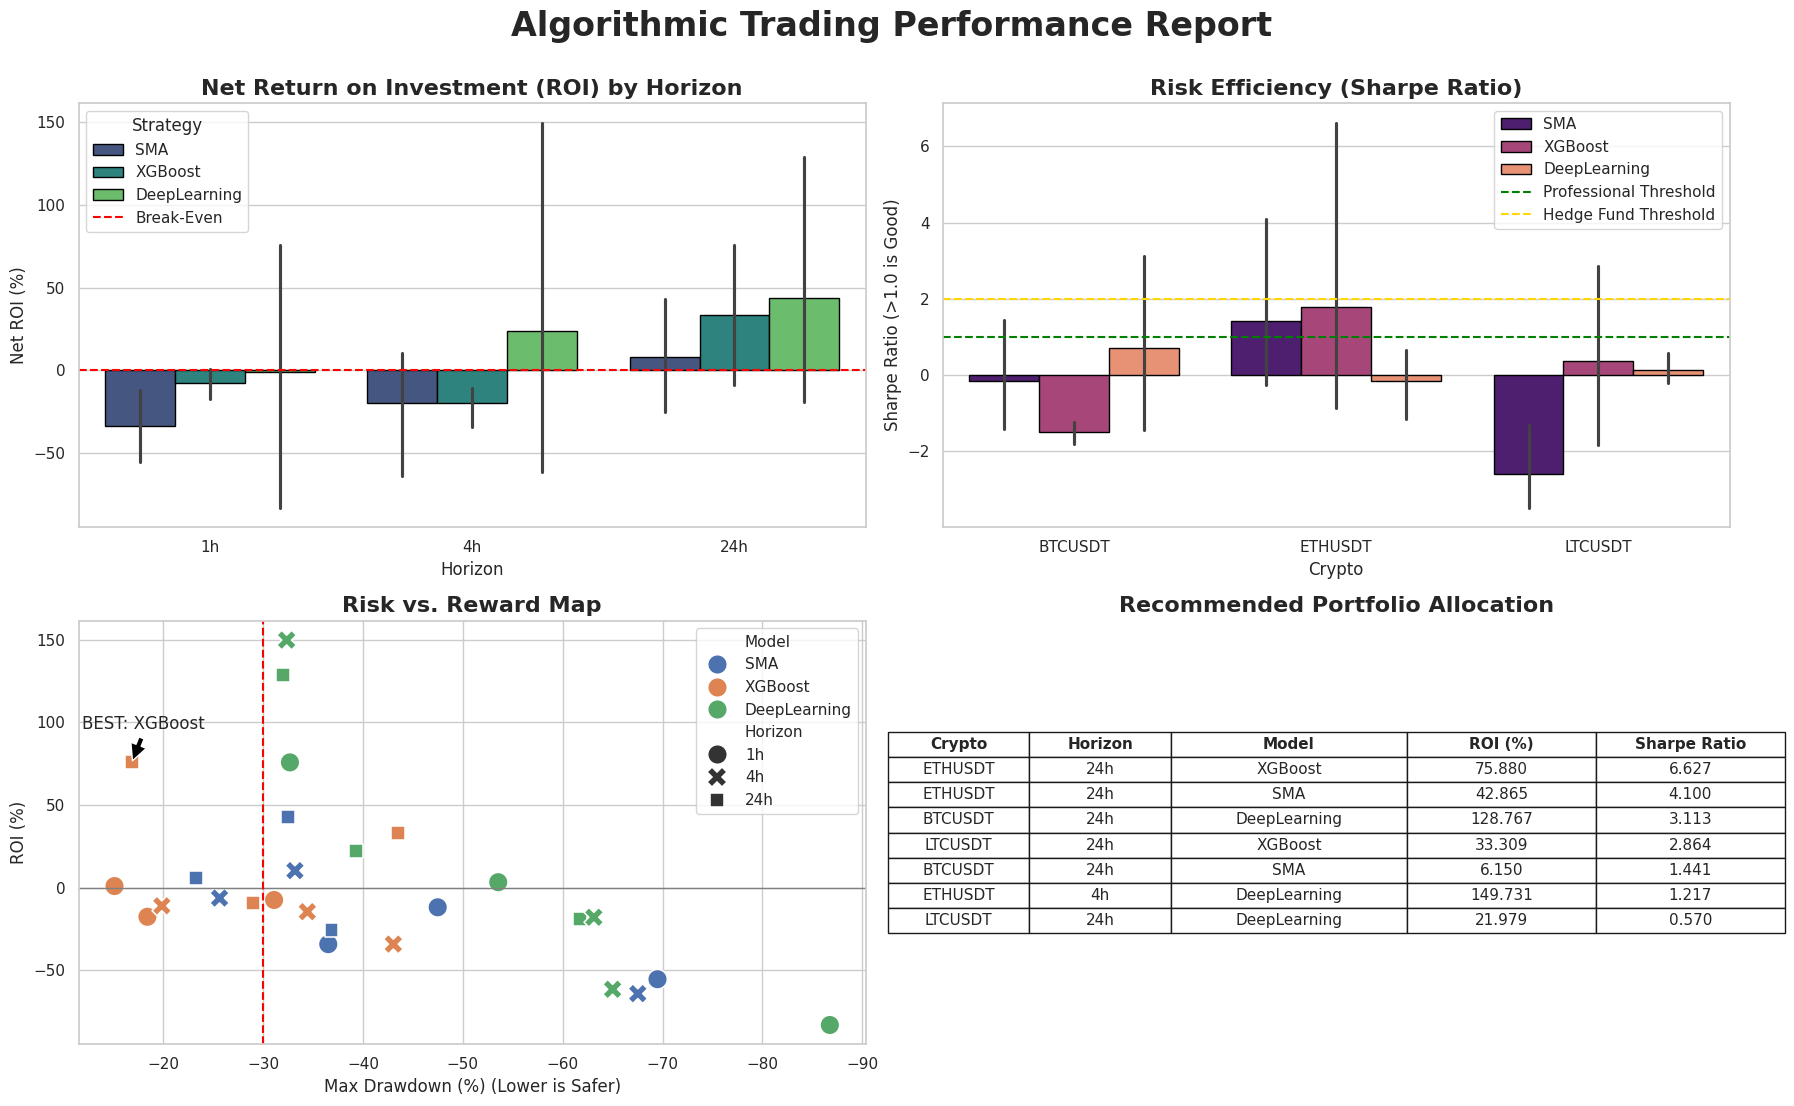

In [34]:
# --- EXECUTE DASHBOARD ---
# Ensure 'final_scorecard' exists from previous steps
if 'final_scorecard' in locals():
    generate_executive_dashboard(final_scorecard)
else:
    print("⚠️ Please run the 'compare_all_models' function first to generate 'final_scorecard'.")

In [35]:
import shutil
import os

# Define the target name
zip_base_name = 'complete_analysis_data'
zip_filename = f"{zip_base_name}.zip"
analysis_dir = '/kaggle/working/analysis_data'

# 1. Remove the previous zip file if it exists
if os.path.exists(zip_filename):
    os.remove(zip_filename)
    print(f"🗑️ Removed existing '{zip_filename}' to ensure a clean archive.")

# 2. Create the new Zip File
# Note: We zip '.' (current directory) or specifically the analysis_dir
shutil.make_archive(zip_base_name, 'zip', analysis_dir)

print(f"\n🎉 Success! Created '{zip_filename}'. You can now download it from the file browser.")

🗑️ Removed existing 'complete_analysis_data.zip' to ensure a clean archive.

🎉 Success! Created 'complete_analysis_data.zip'. You can now download it from the file browser.
